In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ==========================================
# 1. Load Data
# ==========================================
FOLDER_PATH = '../preprocess/'
try:
    df_g1 = pd.read_pickle(f'{FOLDER_PATH}df_g1_processed.pkl')
    df_g2 = pd.read_pickle(f'{FOLDER_PATH}df_g2_processed.pkl')
    print("Data loaded successfully.")
except FileNotFoundError:
    # デバッグ用ダミーデータ生成（ファイルがない場合でも動作確認できるように）
    print("Warning: Pickle files not found. Creating dummy data for testing...")
    dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='B')
    df_g1 = pd.DataFrame(index=dates)
    df_g1['SP500_rtn'] = np.random.normal(0.0005, 0.01, size=len(dates))
    df_g1['SP500_vol'] = df_g1['SP500_rtn'].rolling(20).std() * np.sqrt(252)
    df_g1['Quarter_ID'] = df_g1.index.to_period('Q').astype(str)

    df_g2 = df_g1.copy() # ダミー複製
    print("Dummy data created.")

Data loaded successfully.


In [4]:
# ==========================================
# 2. Seasonality Analysis Function (NEW)
# ==========================================
def plot_seasonality_analysis(df, group_name):
    """
    Plots Seasonal Trends:
    1. Monthly Return Heatmap (Year vs Month)
    2. Average Monthly Return (Bar Chart)
    """
    print(f"\nRunning Seasonality Analysis for: {group_name}")

    # Identify return columns
    ret_cols = [c for c in df.columns if c.endswith('rtn')]

    if not ret_cols:
        print("No return columns found for seasonality analysis.")
        return

    # Prepare Data for Seasonality
    # Ensure index is datetime
    df_season = df.copy()
    if not isinstance(df_season.index, pd.DatetimeIndex):
        try:
            df_season.index = pd.to_datetime(df_season.index)
        except:
            print("Error: Index could not be converted to Datetime.")
            return

    df_season['Year'] = df_season.index.year
    df_season['Month'] = df_season.index.month

    # Generate plots for each asset
    for col in ret_cols:
        asset_name = col.replace('_rtn', '').replace('rtn', '')

        # Create a pivot table for Heatmap: Year x Month
        # Resample to monthly returns first to get the total return for that month
        # (Assuming input is daily returns, we sum them for approx monthly return)
        monthly_data = df_season.groupby(['Year', 'Month'])[col].sum().unstack()

        # Calculate Stats per Month across all years
        monthly_stats = df_season.groupby('Month')[col].mean() * 21 # Approx monthly return avg
        monthly_win_rate = df_season.groupby('Month')[col].apply(lambda x: (x > 0).mean())

        # --- PLOT ---
        fig = plt.figure(figsize=(18, 6))
        plt.suptitle(f"Seasonal Trends: {asset_name}", fontsize=16, y=0.98)

        # 1. Heatmap (Year vs Month)
        ax1 = plt.subplot(1, 2, 1)
        sns.heatmap(monthly_data, cmap='RdYlGn', center=0, annot=True, fmt=".1%",
                    cbar_kws={'label': 'Monthly Return'}, ax=ax1)
        ax1.set_title('Monthly Returns Heatmap (Year x Month)')
        ax1.set_ylabel('Year')
        ax1.set_xlabel('Month')

        # 2. Bar Chart (Average Return by Month)
        ax2 = plt.subplot(1, 2, 2)
        colors = ['red' if x < 0 else 'green' for x in monthly_stats]
        monthly_stats.plot(kind='bar', color=colors, ax=ax2, alpha=0.7)

        # Add a line for win rate (optional, on secondary axis)
        ax2_twin = ax2.twinx()
        ax2_twin.plot(monthly_stats.index - 1, monthly_win_rate, color='blue', marker='o', linestyle='--', label='Win Rate')
        ax2_twin.set_ylabel('Win Rate (%)', color='blue')
        ax2_twin.set_ylim(0, 1)

        ax2.set_title('Average Monthly Return & Win Rate (Seasonality)')
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Avg Monthly Return')
        ax2.grid(axis='y', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()

In [5]:
# ==========================================
# 3. Visualization Function (Base)
# ==========================================
def plot_asset_group_analysis(df, group_name, quarter_id=None):
    """
    Plots Correlation, Time Series, and Distributions.
    Looks for columns ending with 'rtn' and 'vol'.
    """
    ret_cols = [c for c in df.columns if c.endswith('rtn')]
    vol_cols = [c for c in df.columns if c.endswith('vol')]

    if not ret_cols:
        return

    plot_df = df.dropna(subset=ret_cols + vol_cols).copy()

    if plot_df.empty:
        return

    fig = plt.figure(figsize=(20, 12))
    title_text = f"Analysis for {group_name}"
    if quarter_id:
        title_text += f" [{quarter_id}]"

    plt.suptitle(title_text, fontsize=20, y=0.95)

    # --- 1. Correlation Matrix ---
    ax1 = plt.subplot(2, 3, 3)
    corr_matrix = plot_df[ret_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax1, fmt=".2f")
    ax1.set_title('Correlation Matrix (Returns)')

    # --- 2. Time Series: Cumulative Returns ---
    ax2 = plt.subplot(2, 3, 1)
    all_cum_rets = (1 + plot_df[ret_cols]).cumprod()
    for col in ret_cols:
        label_name = col.replace('_rtn', '').replace('rtn', '')
        ax2.plot(plot_df.index, all_cum_rets[col], label=label_name, linewidth=1)

    ax2.set_title('Time Series: Cumulative Returns (Zoomed)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # Auto Zoom Y-axis
    y_min = all_cum_rets.min().min()
    y_max = all_cum_rets.max().max()
    margin = (y_max - y_min) * 0.05
    if margin == 0: margin = 0.01
    ax2.set_ylim(y_min - margin, y_max + margin)

    # --- 3. Time Series: Volatility ---
    ax3 = plt.subplot(2, 3, 2)
    for col in vol_cols:
        label_name = col.replace('_vol', '').replace('vol', '')
        ax3.plot(plot_df.index, plot_df[col], label=label_name, linewidth=1, alpha=0.8)
    ax3.set_title('Time Series: Annualized Volatility')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # --- 4. Histogram: Returns ---
    ax4 = plt.subplot(2, 3, 4)
    for col in ret_cols:
        label_name = col.replace('_rtn', '').replace('rtn', '')
        sns.histplot(plot_df[col], kde=True, label=label_name, element="step", stat="density", alpha=0.3, ax=ax4)
    ax4.set_title('Distribution: Log Returns')

    # Limit X-axis for better view
    q_low = plot_df[ret_cols].quantile(0.005).min()
    q_high = plot_df[ret_cols].quantile(0.995).max()
    ax4.set_xlim(q_low, q_high)
    ax4.legend()

    # --- 5. Histogram: Volatility ---
    ax5 = plt.subplot(2, 3, 5)
    for col in vol_cols:
        label_name = col.replace('_vol', '').replace('vol', '')
        try:
            sns.kdeplot(plot_df[col], label=label_name, fill=True, alpha=0.2, ax=ax5)
        except:
            pass
    ax5.set_title('Distribution: Volatility (Density)')
    vol_max = plot_df[vol_cols].quantile(0.99).max()
    if pd.notna(vol_max) and vol_max > 0:
        ax5.set_xlim(0, vol_max)
    ax5.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


############################################################
 FULL ANALYSIS START: Group 1 (Indices)
############################################################

Running Seasonality Analysis for: Group 1 (Indices)


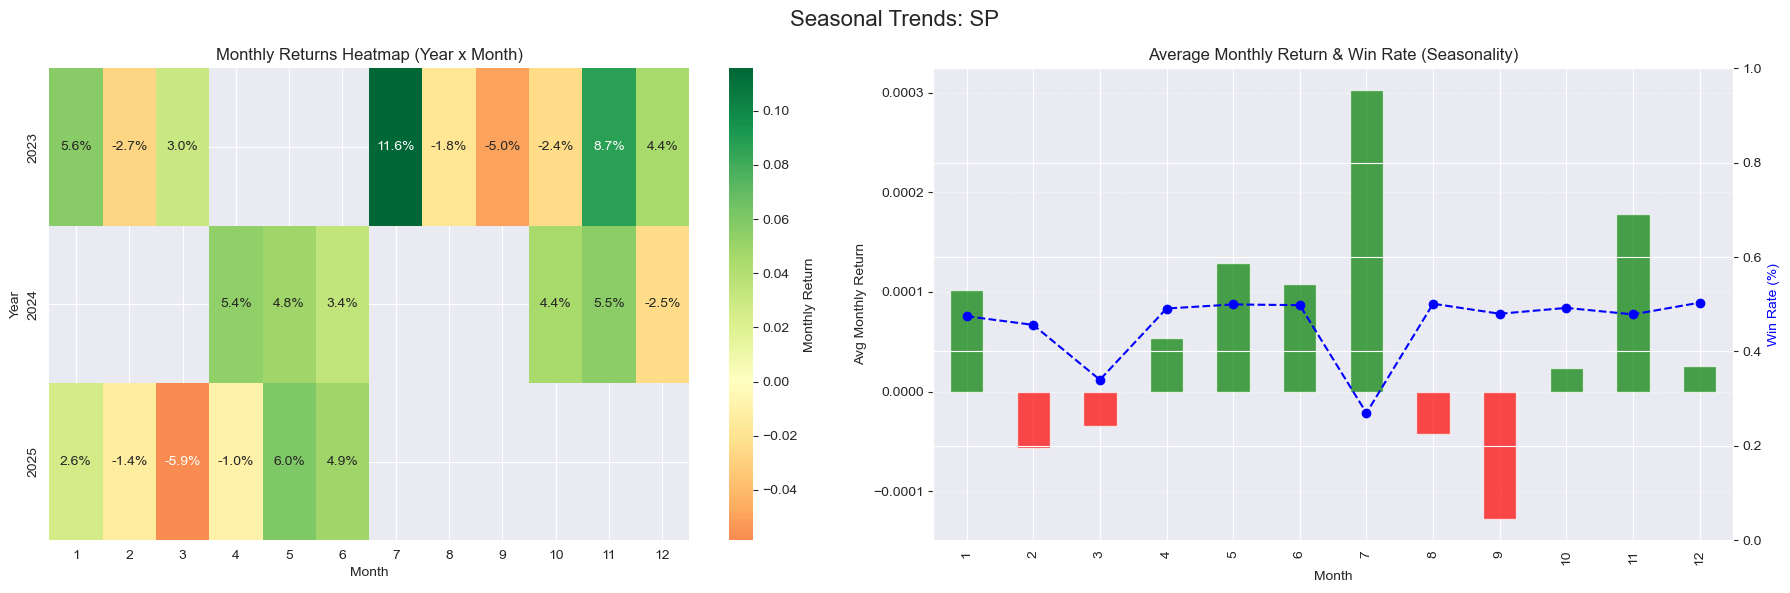

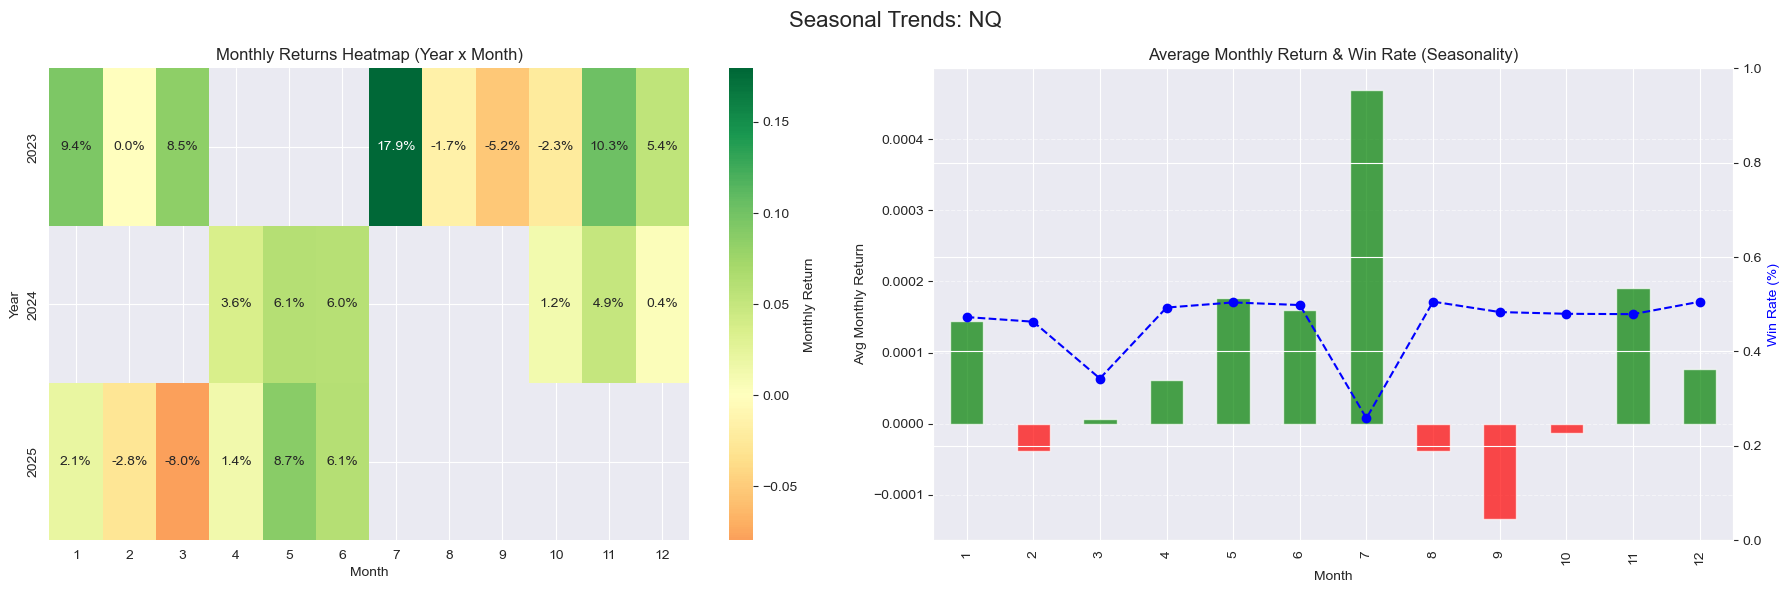


Processing Quarterly Breakdown for: Group 1 (Indices)
Quarters found: 7
 > Quarter: 2023_Q1


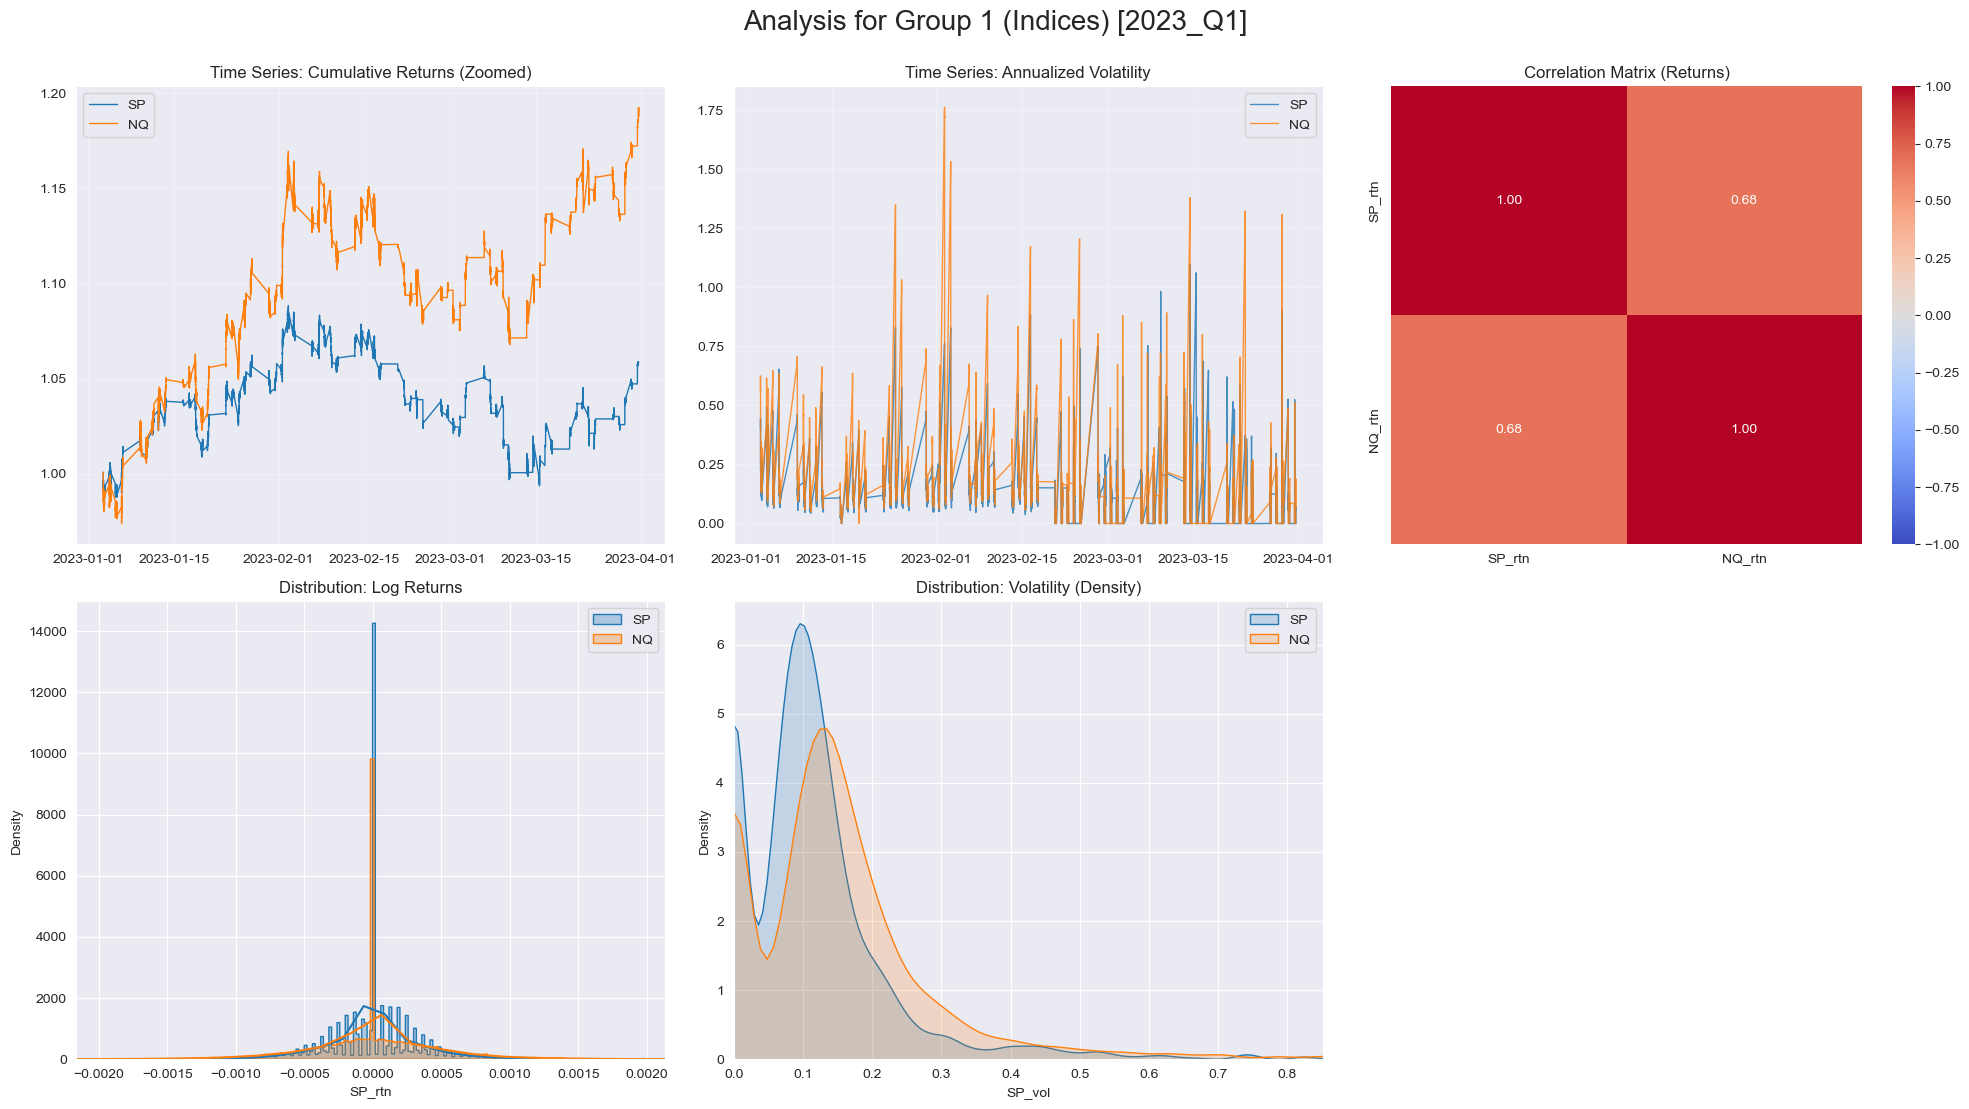

------------------------------
 > Quarter: 2023_Q3


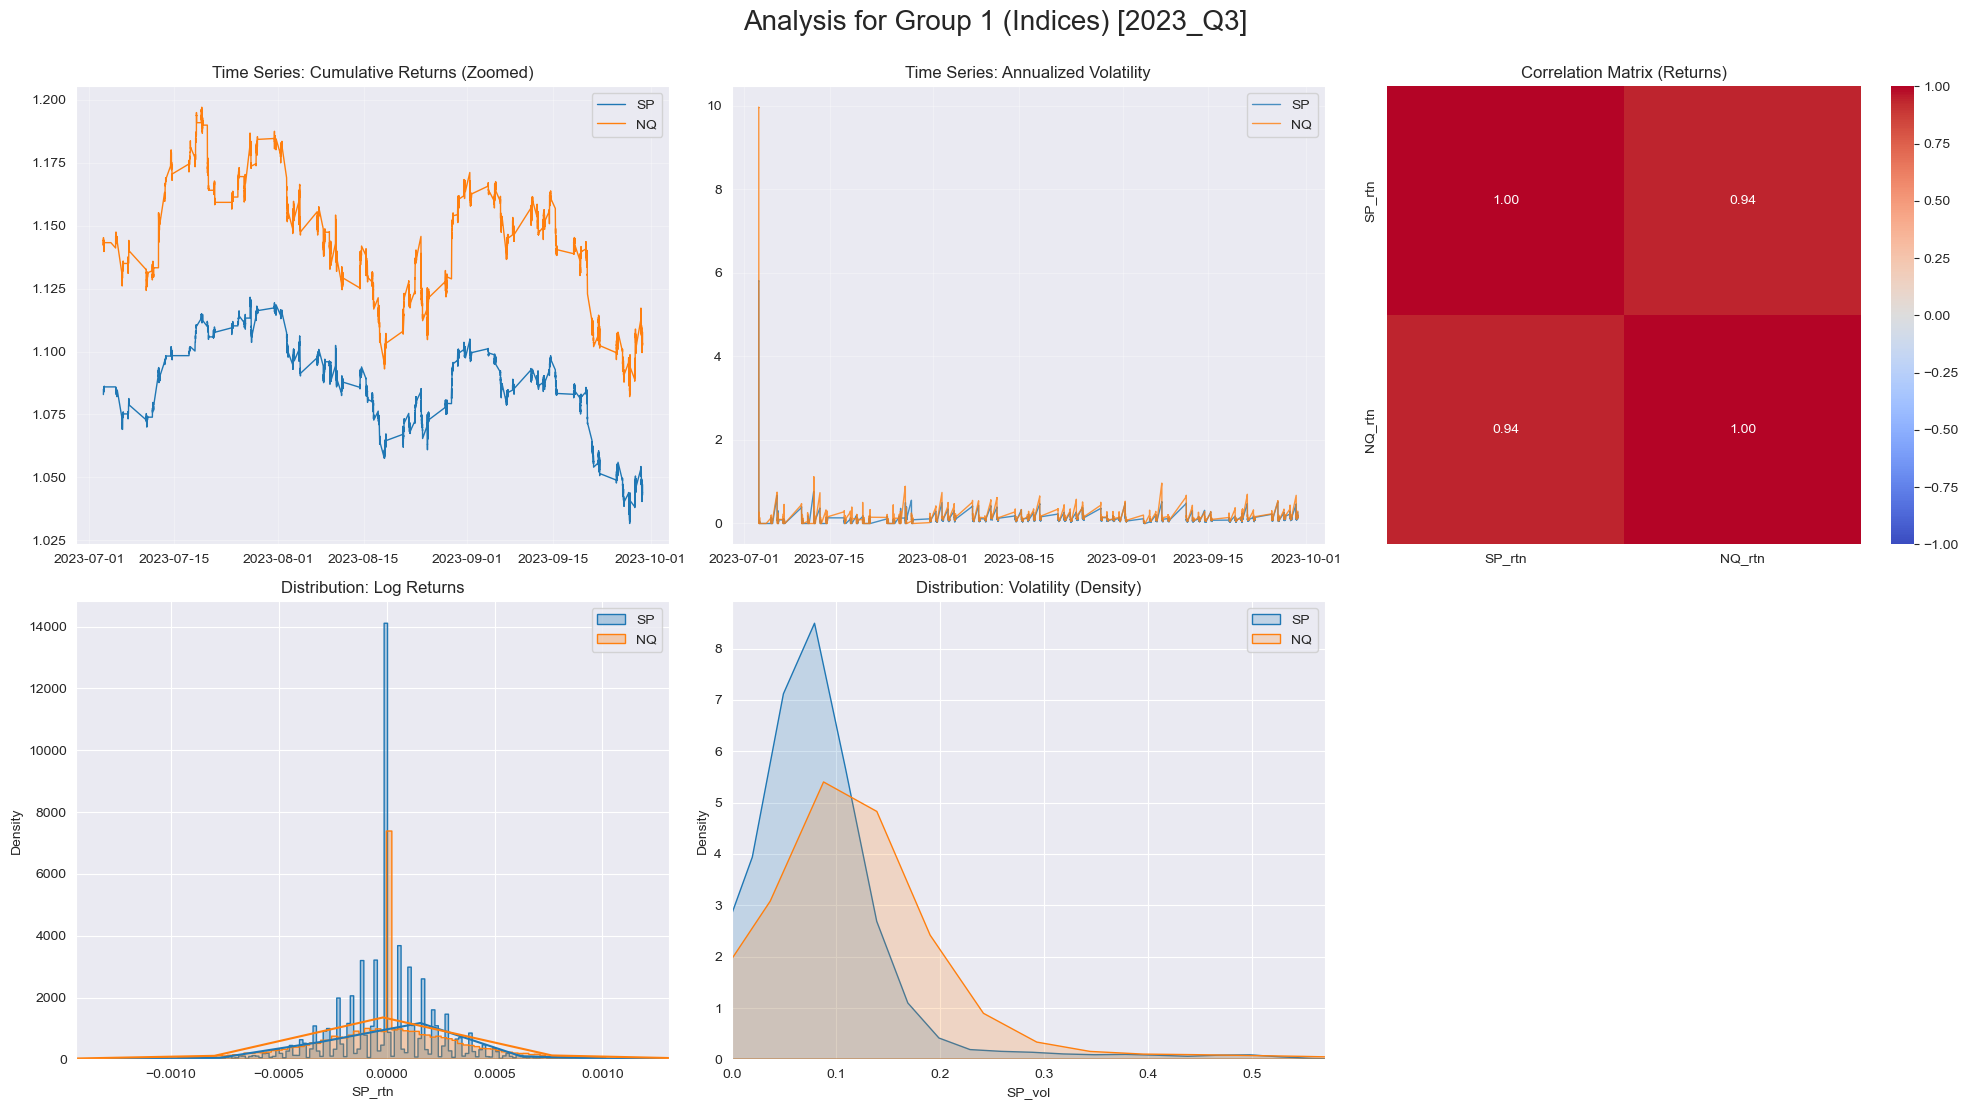

------------------------------
 > Quarter: 2023_Q4


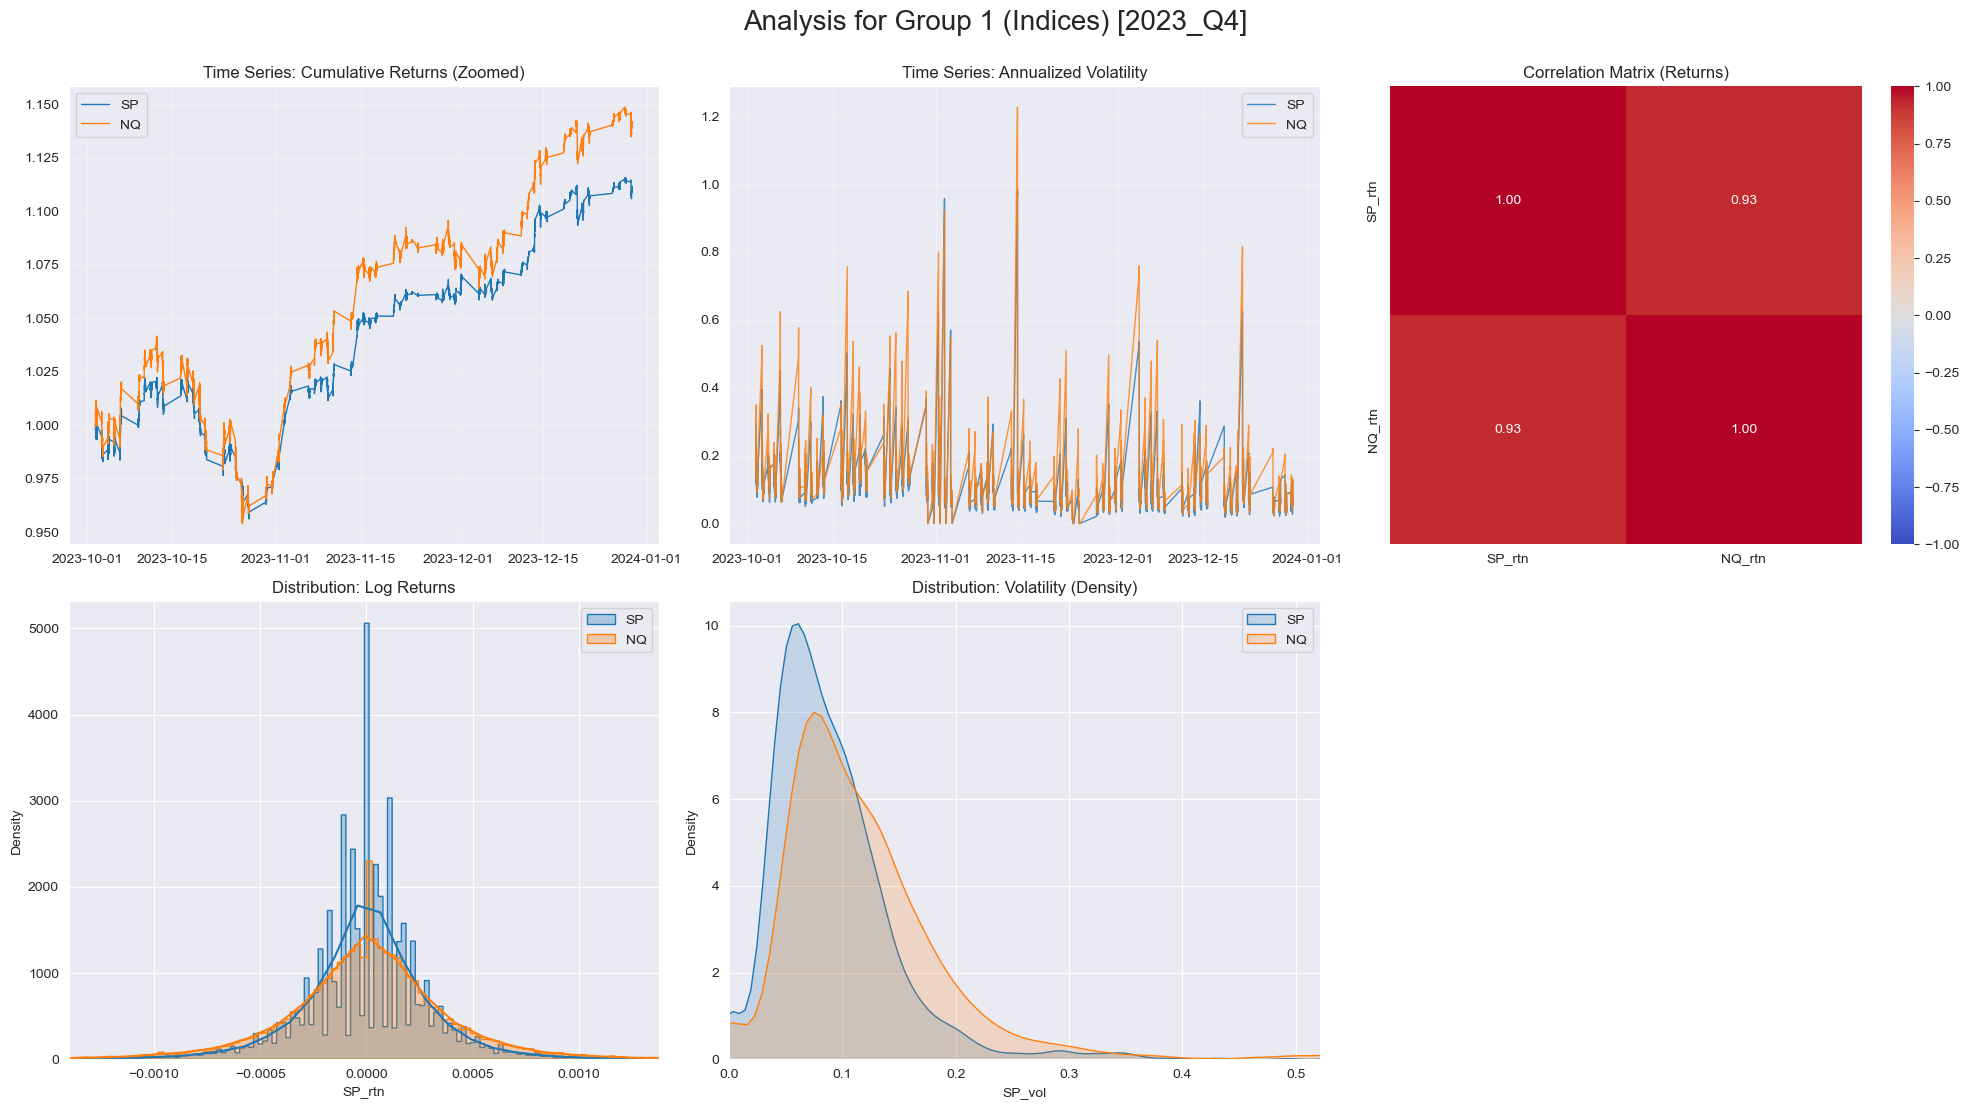

------------------------------
 > Quarter: 2024_Q2


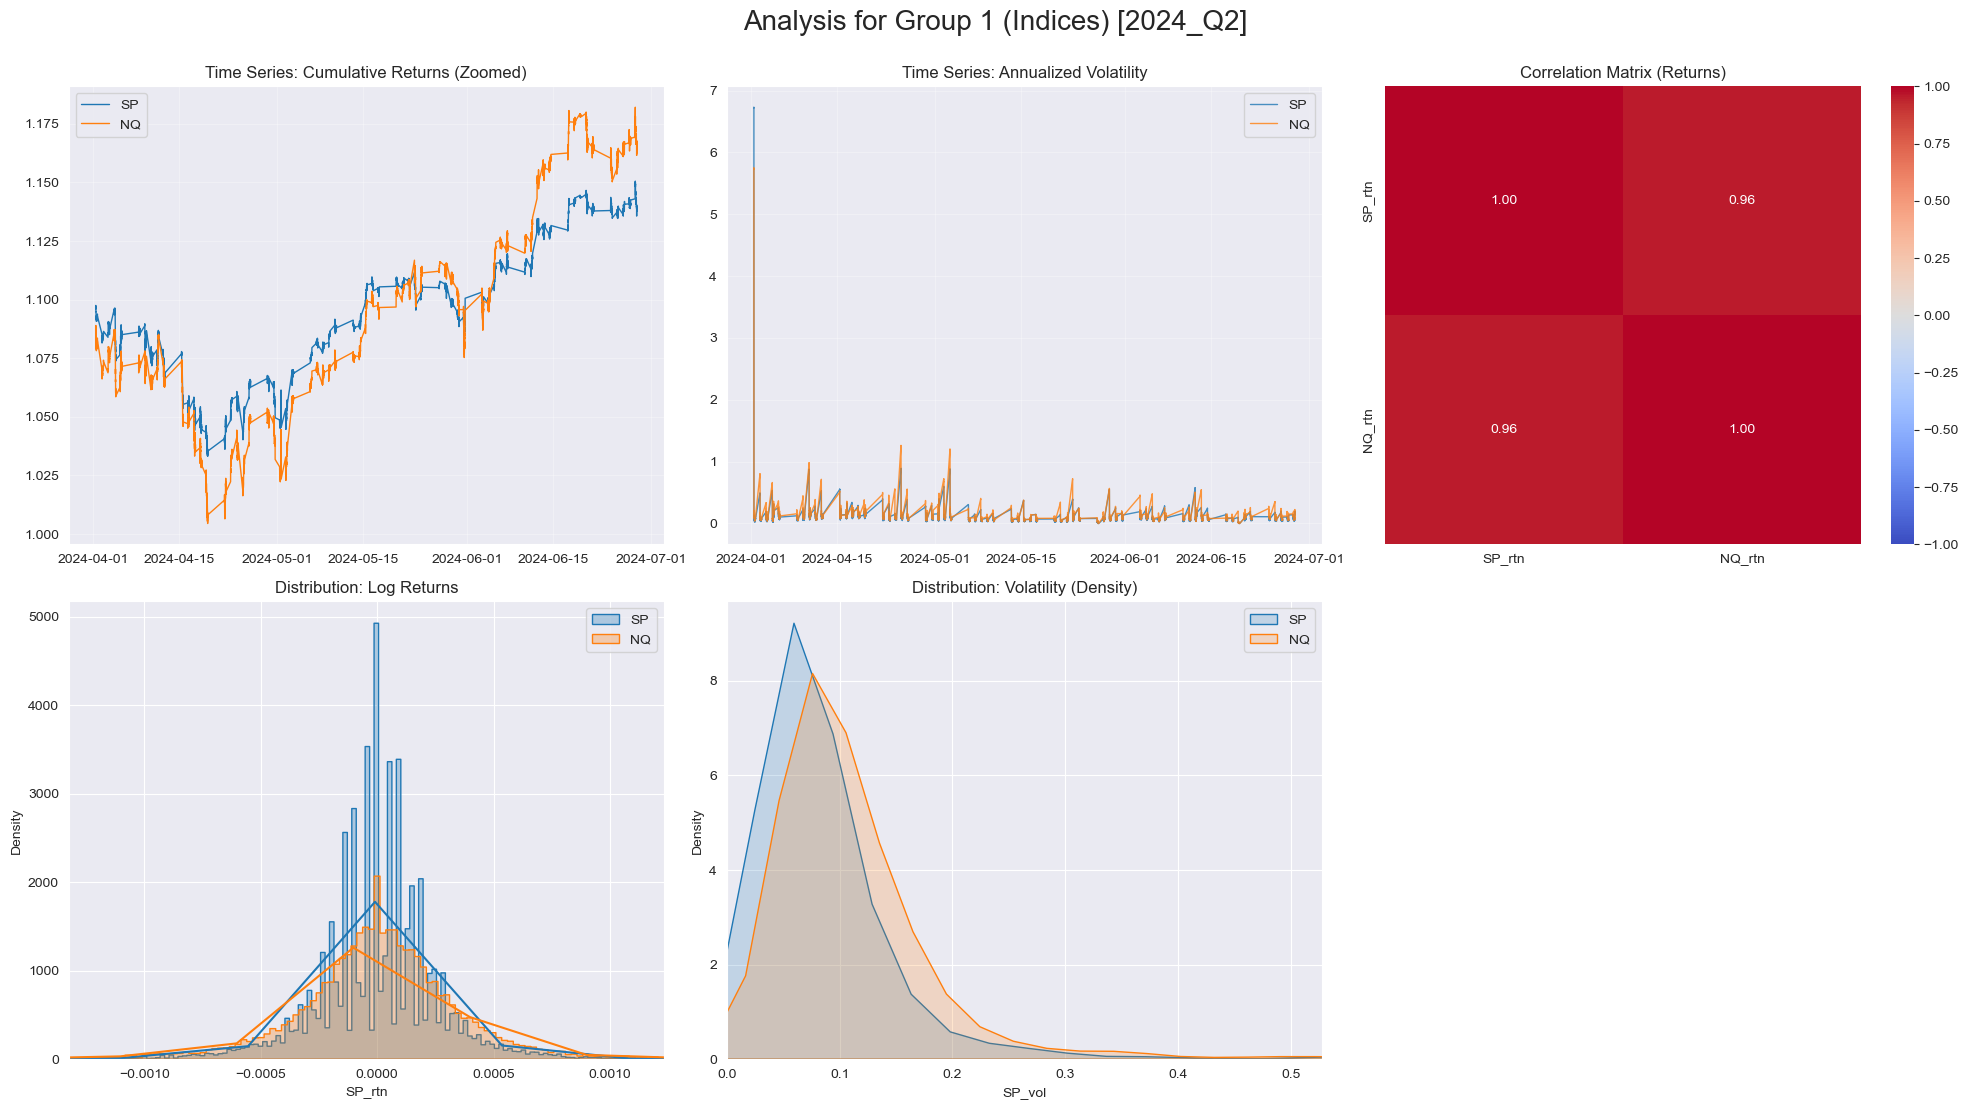

------------------------------
 > Quarter: 2024_Q4


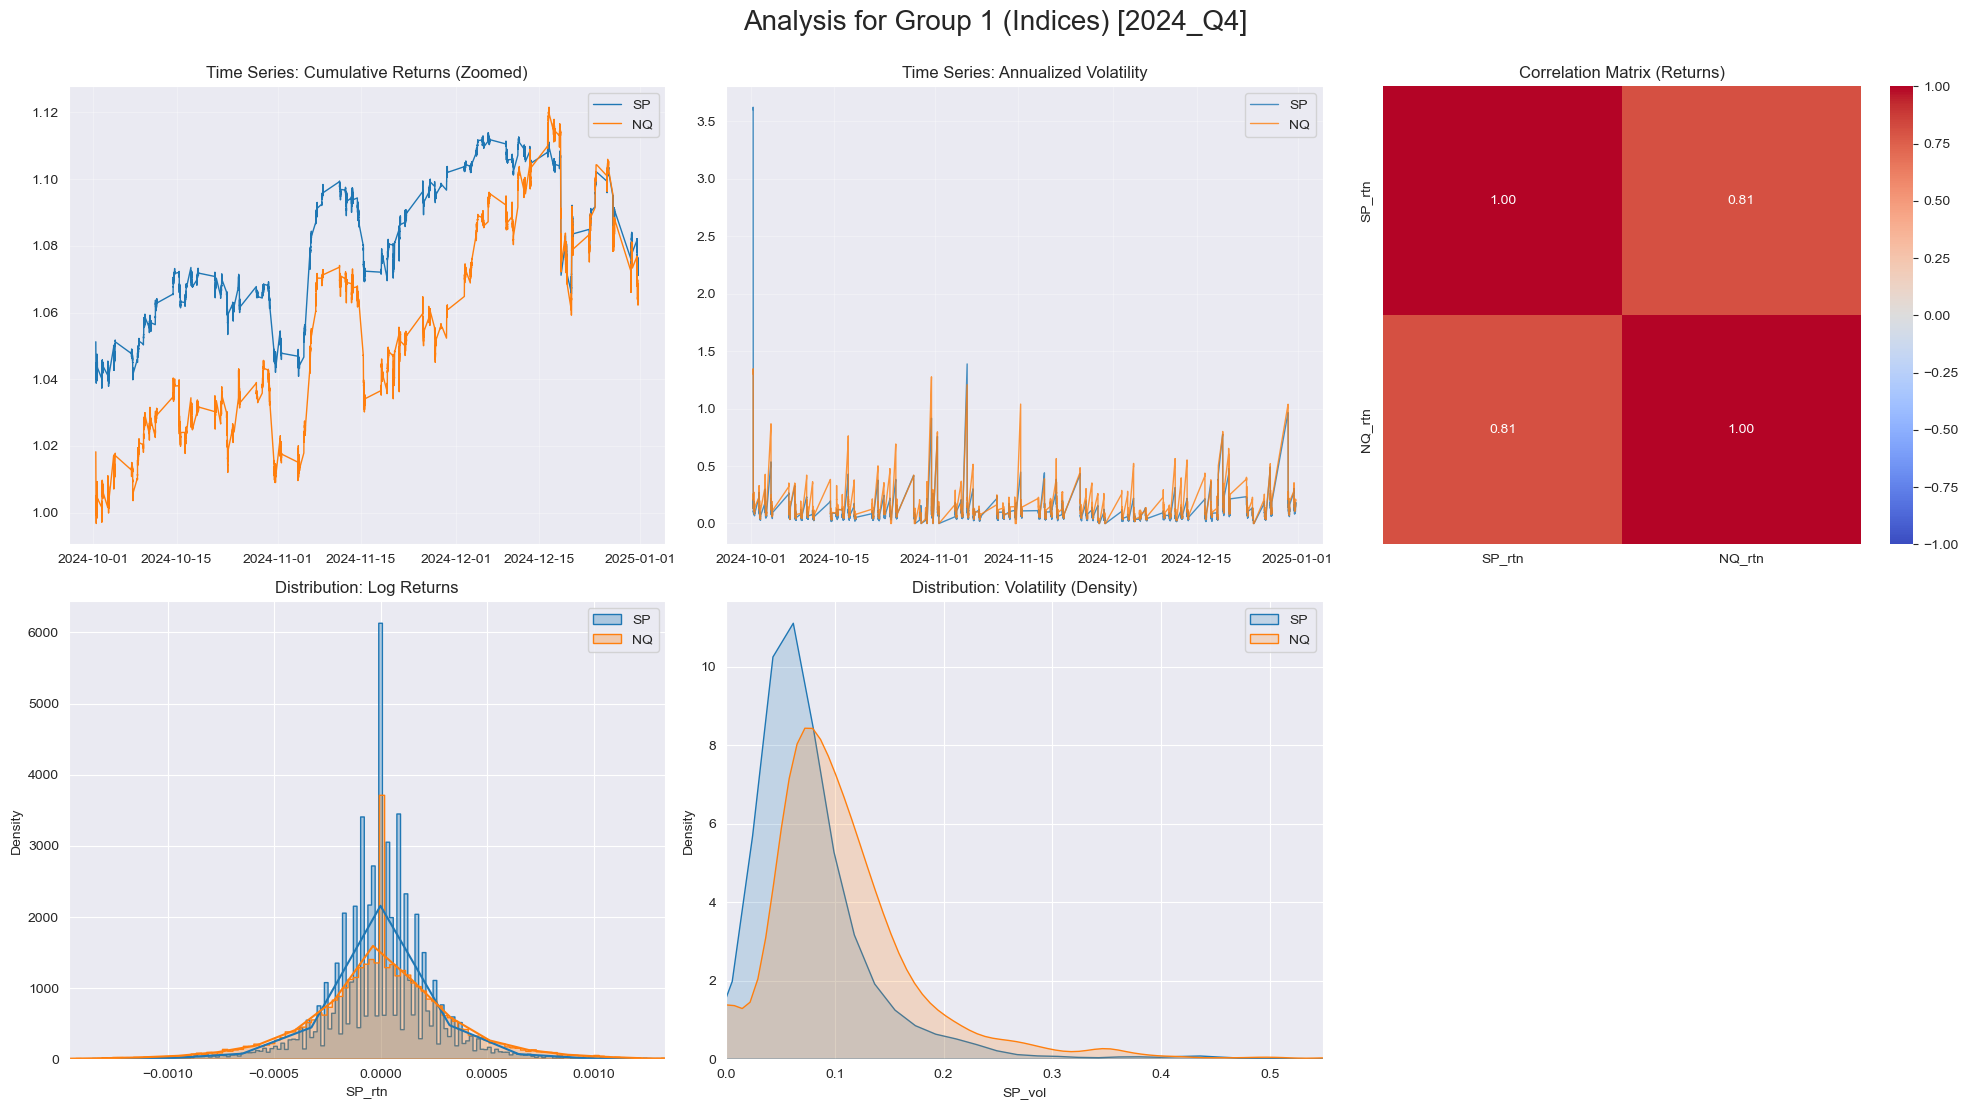

------------------------------
 > Quarter: 2025_Q1


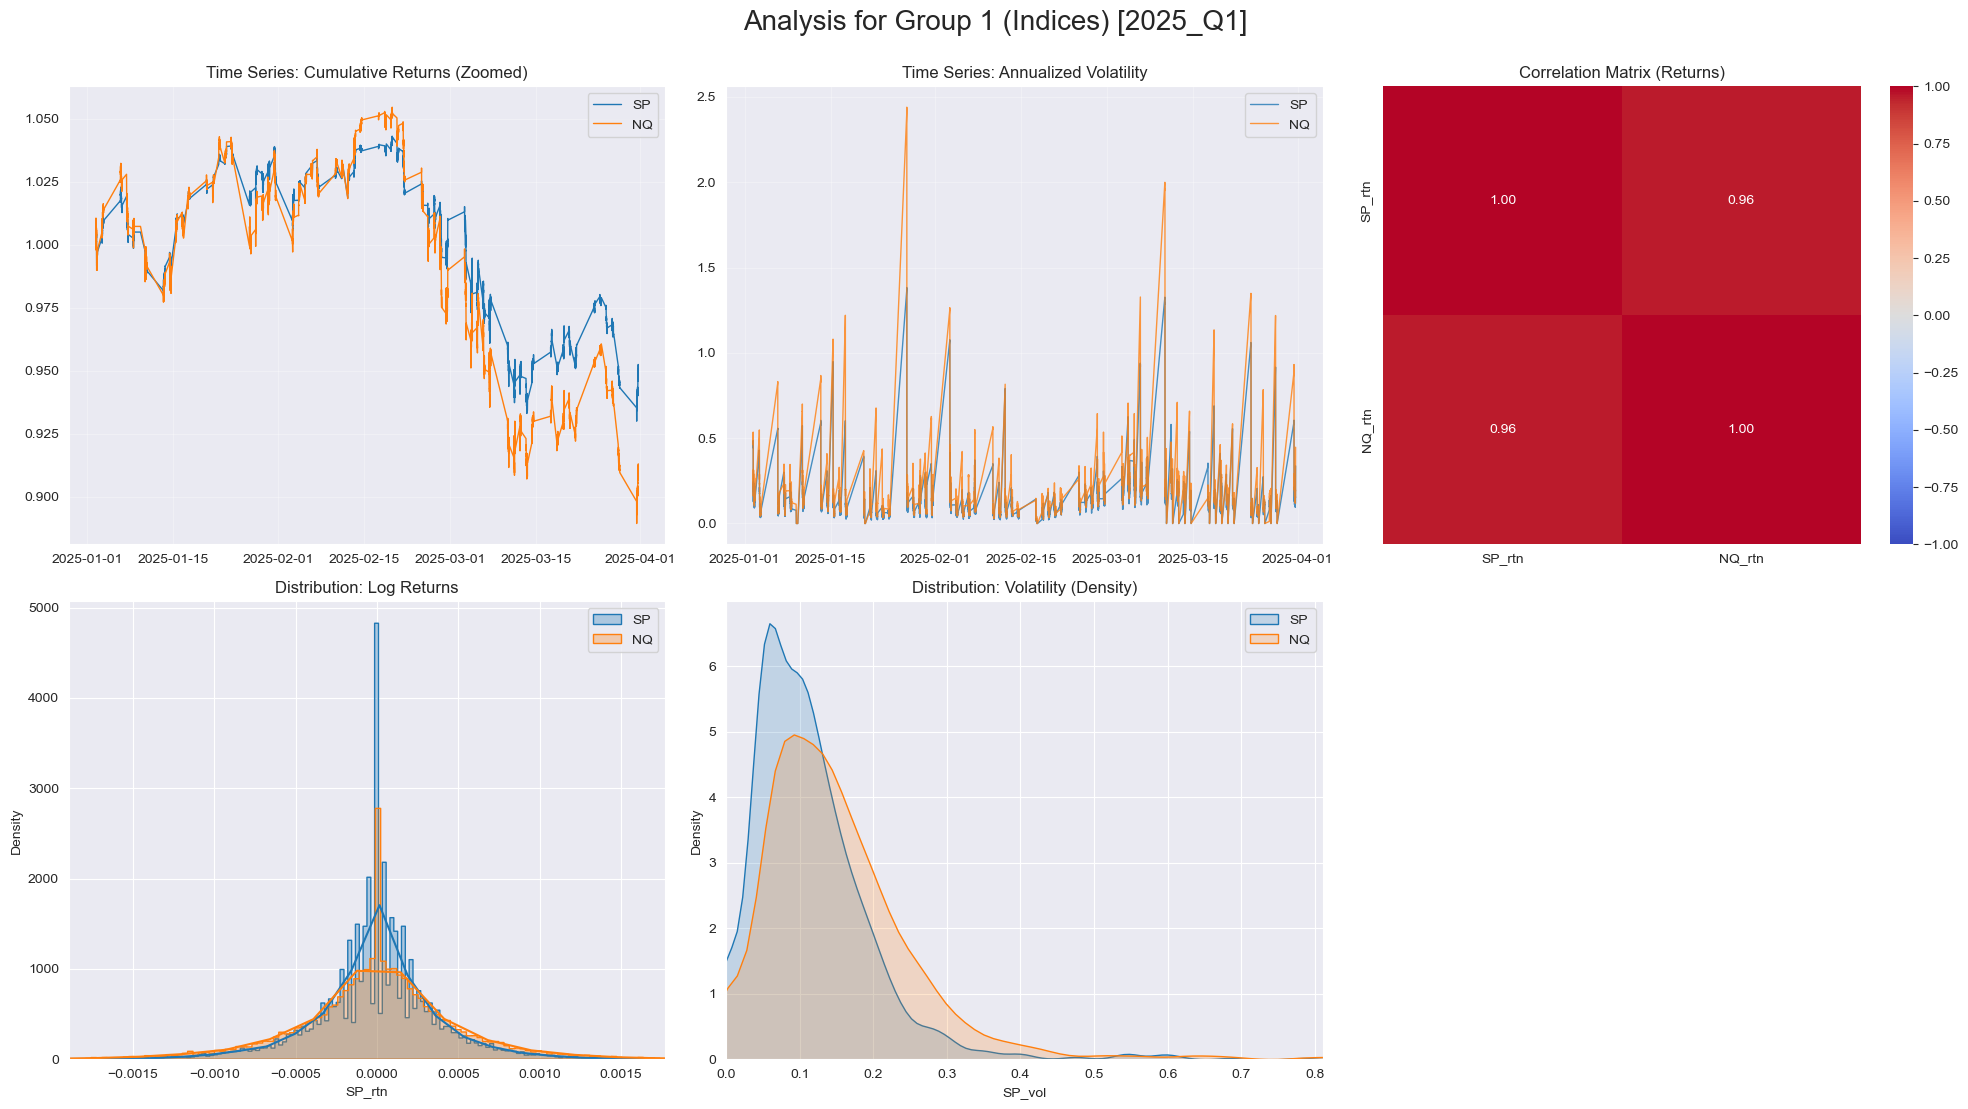

------------------------------
 > Quarter: 2025_Q2


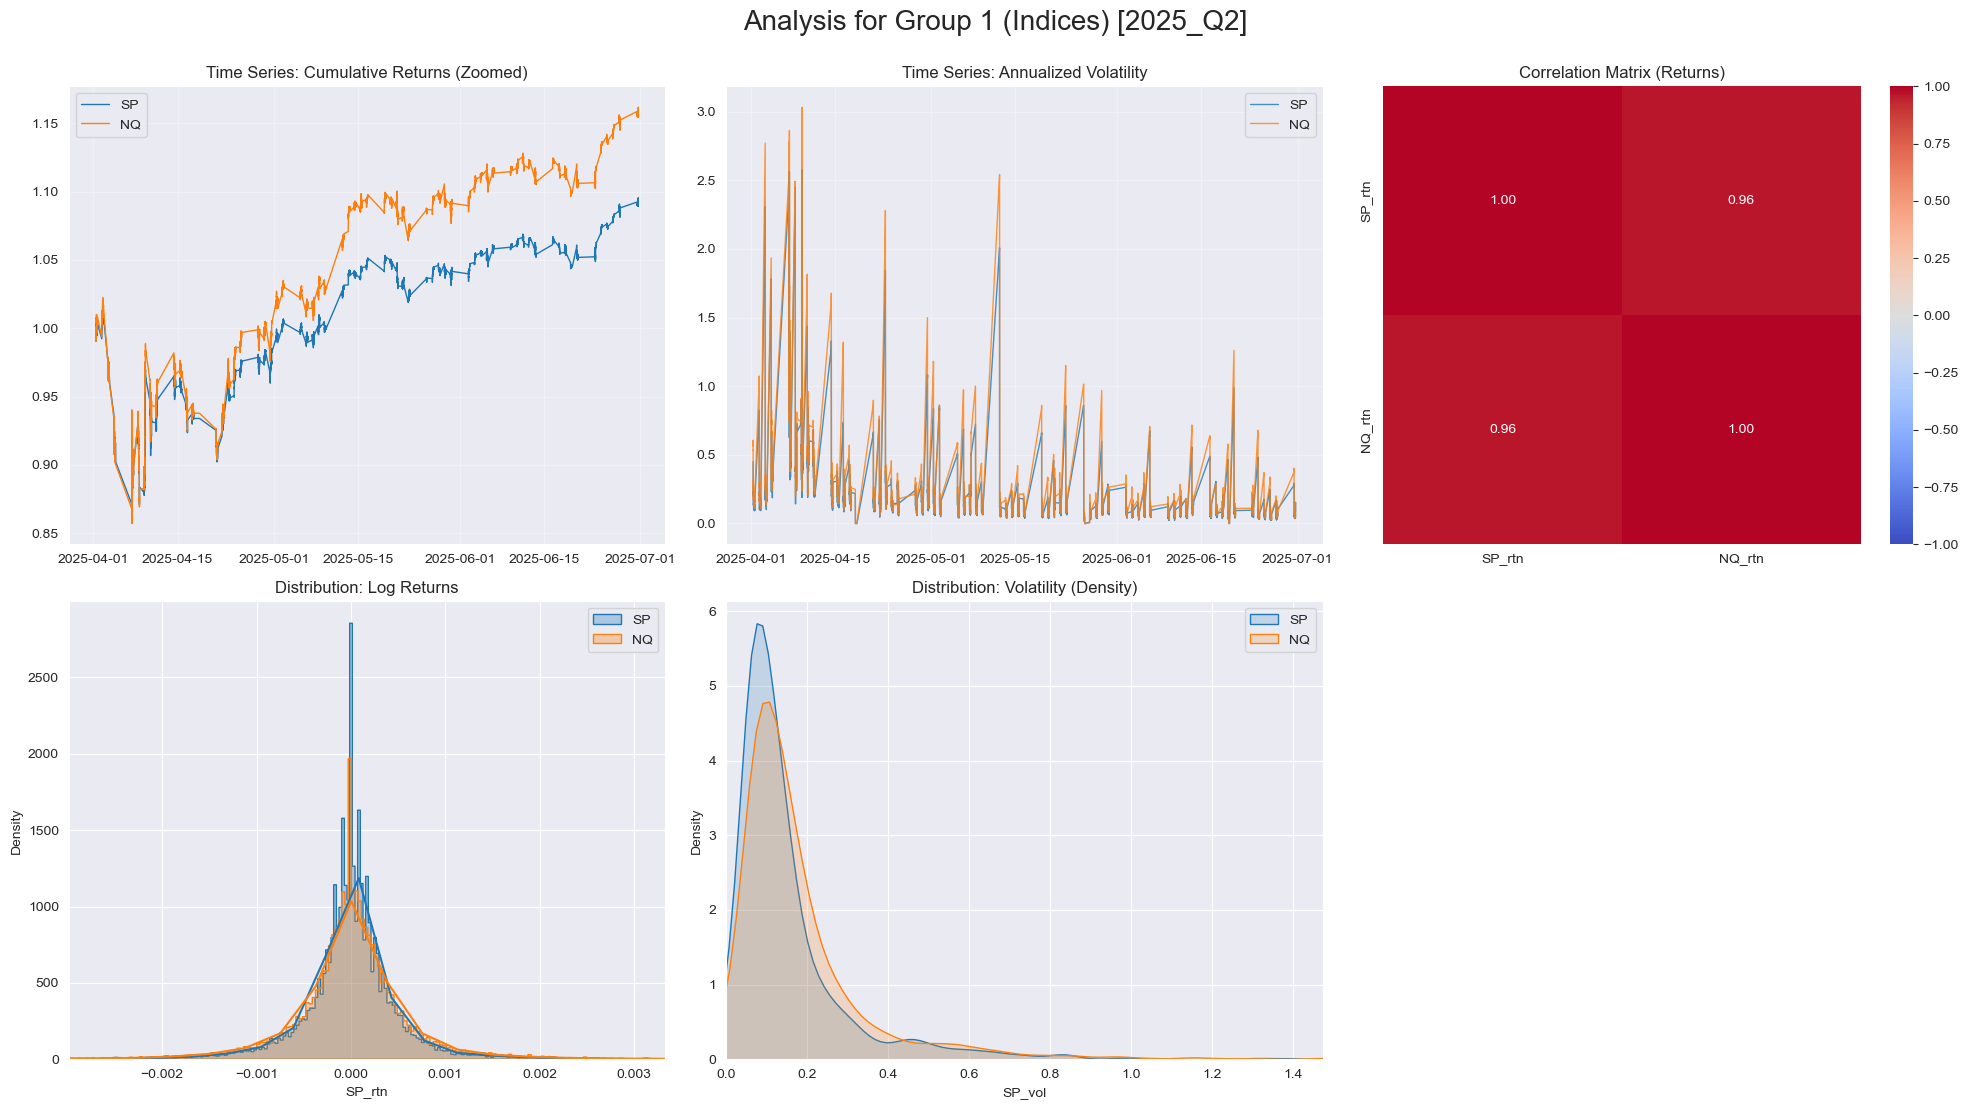

------------------------------

############################################################
 FULL ANALYSIS START: Group 2 (FX/Commodities)
############################################################

Running Seasonality Analysis for: Group 2 (FX/Commodities)


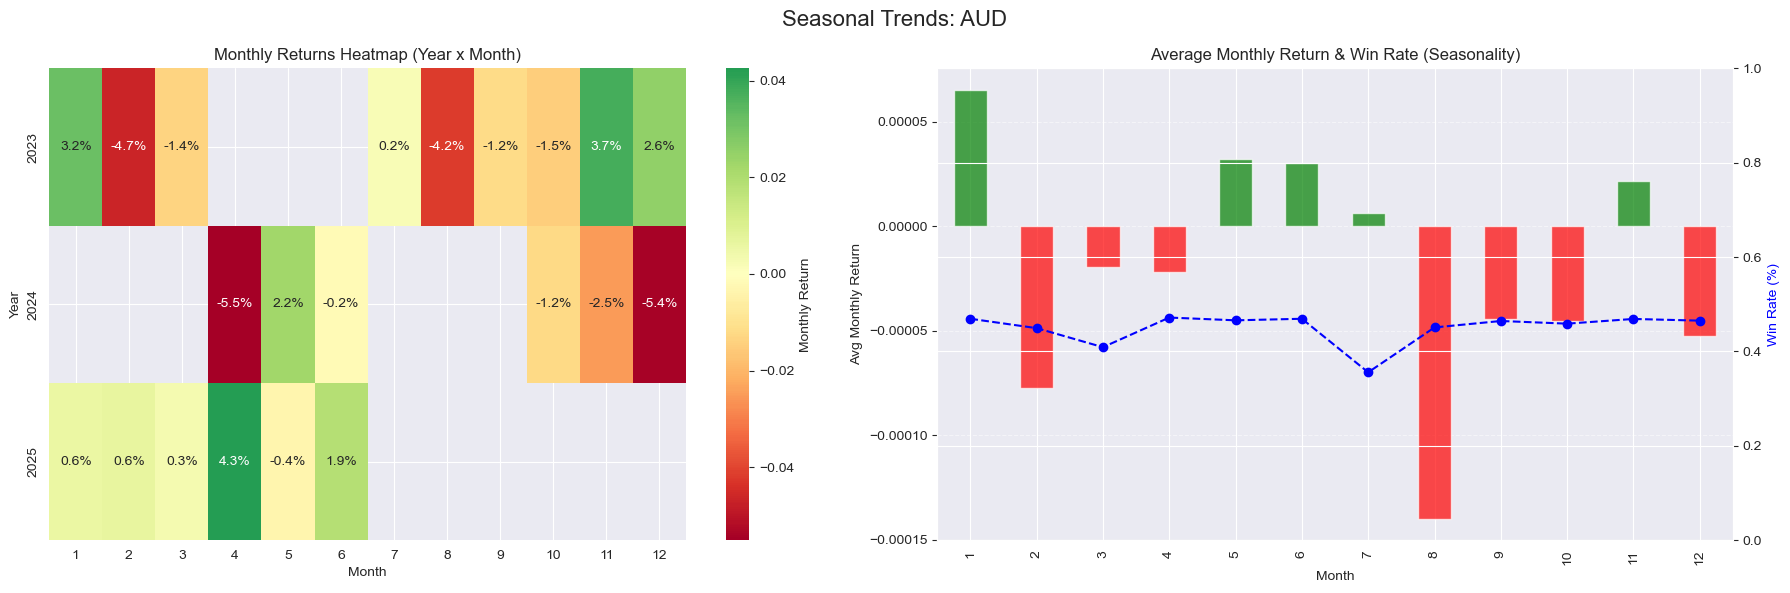

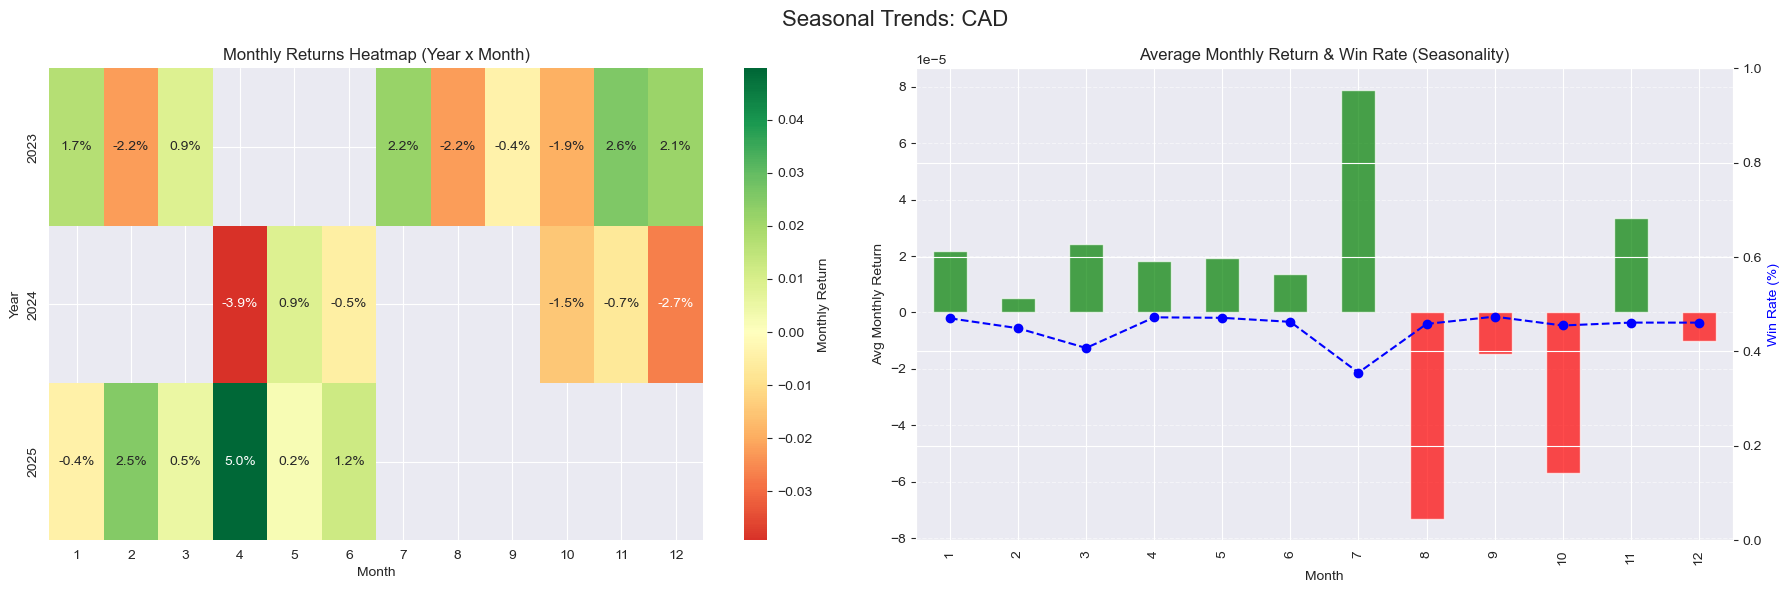

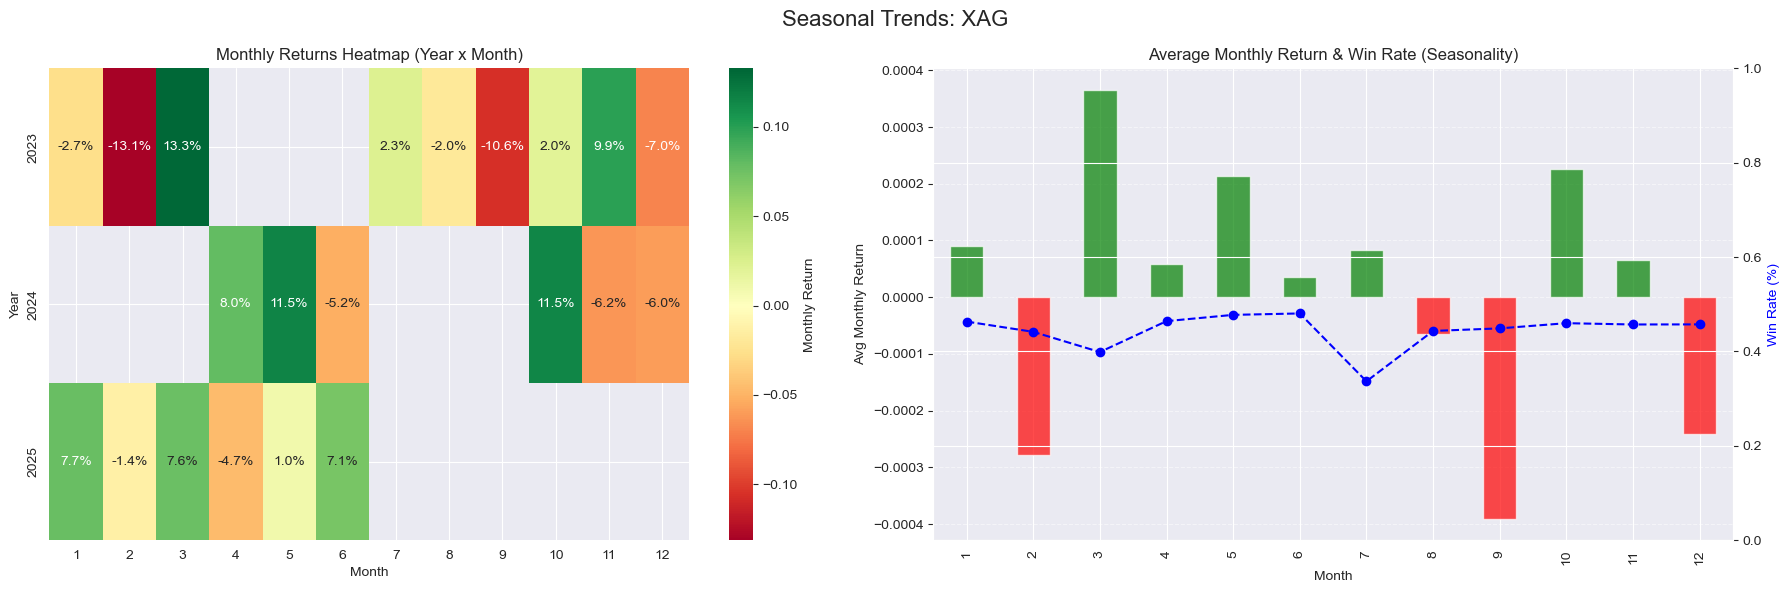

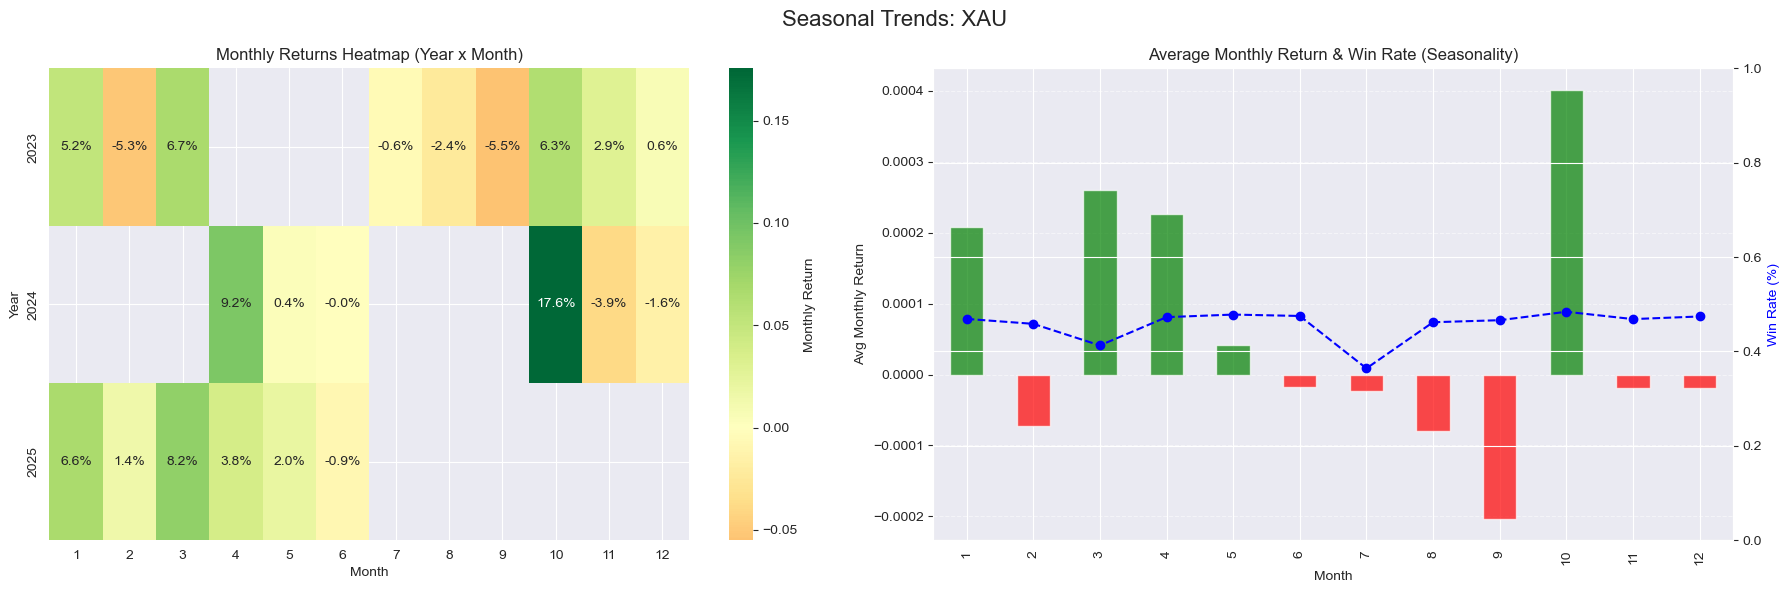


Processing Quarterly Breakdown for: Group 2 (FX/Commodities)
Quarters found: 7
 > Quarter: 2023_Q1


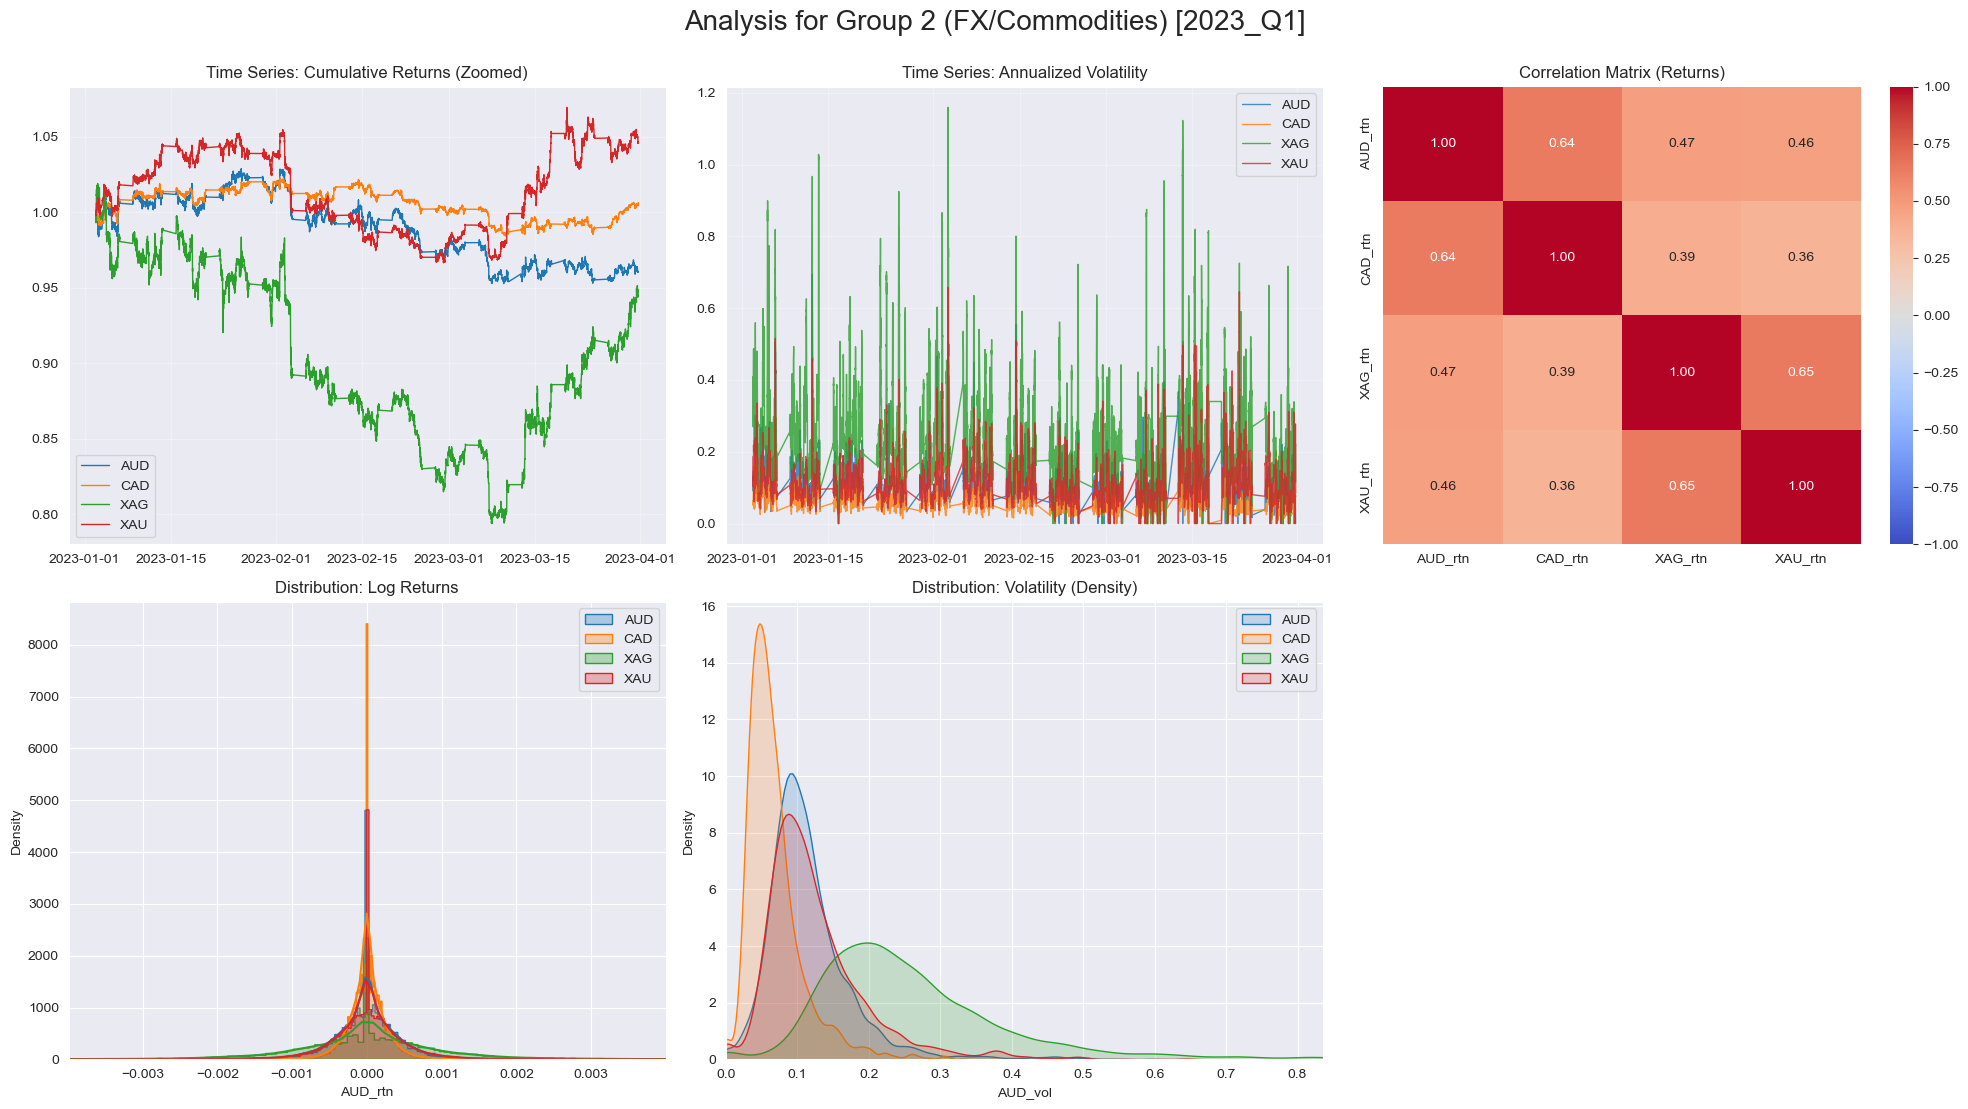

------------------------------
 > Quarter: 2023_Q3


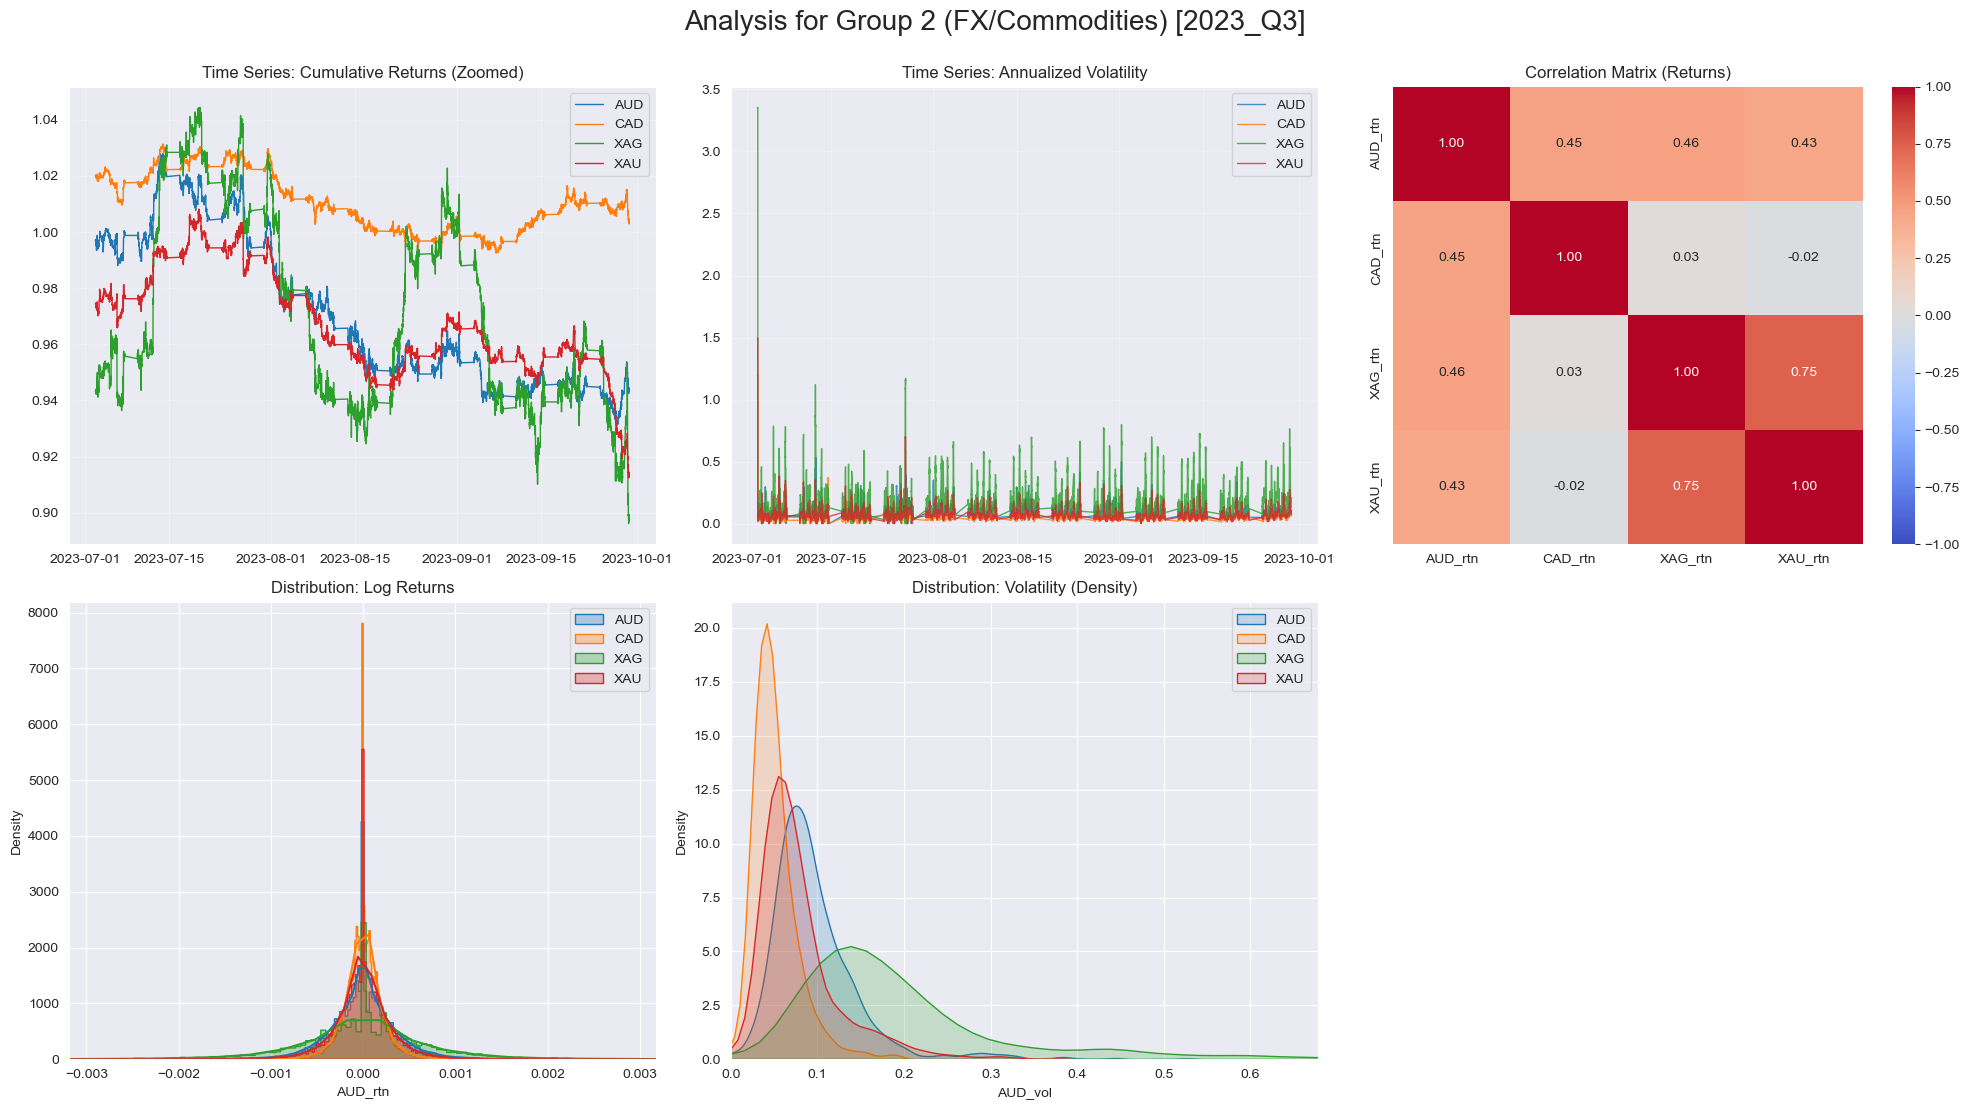

------------------------------
 > Quarter: 2023_Q4


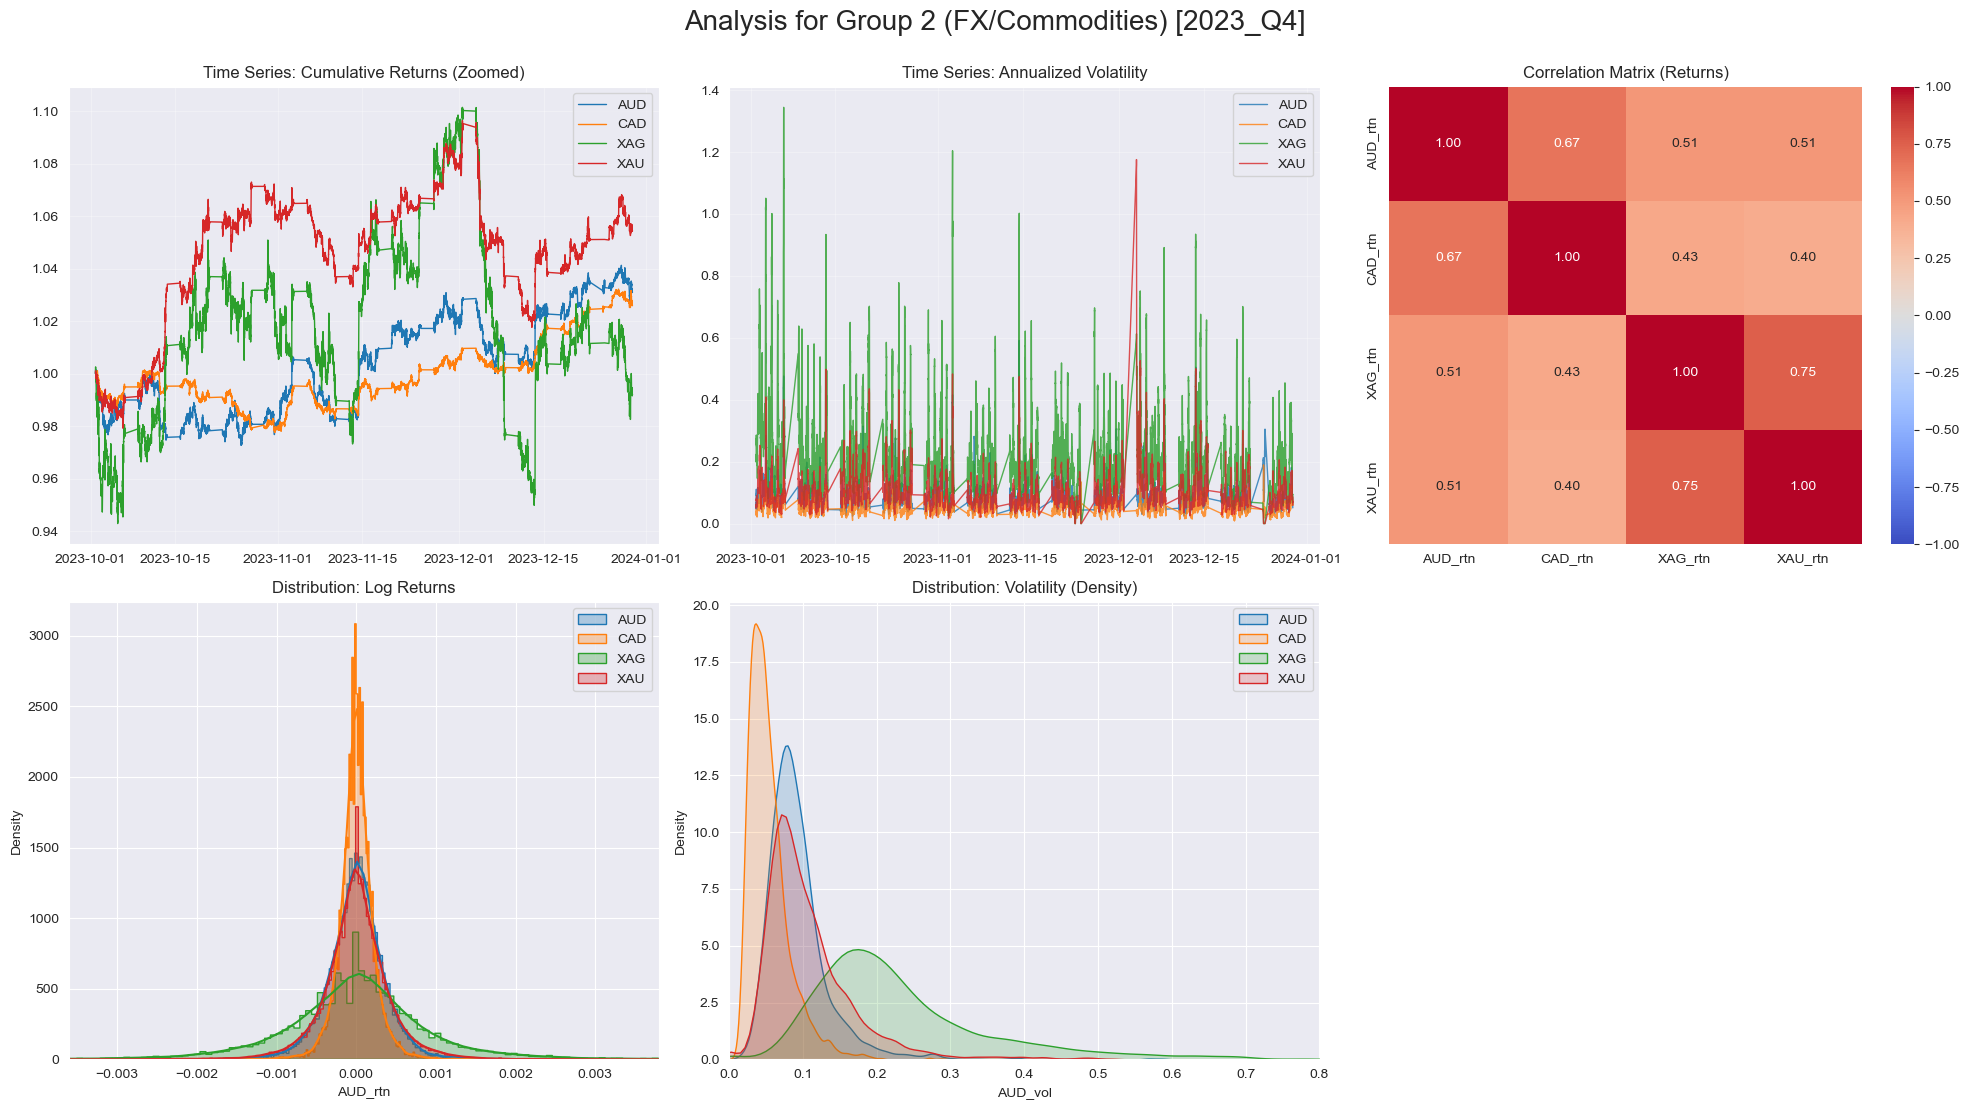

------------------------------
 > Quarter: 2024_Q2


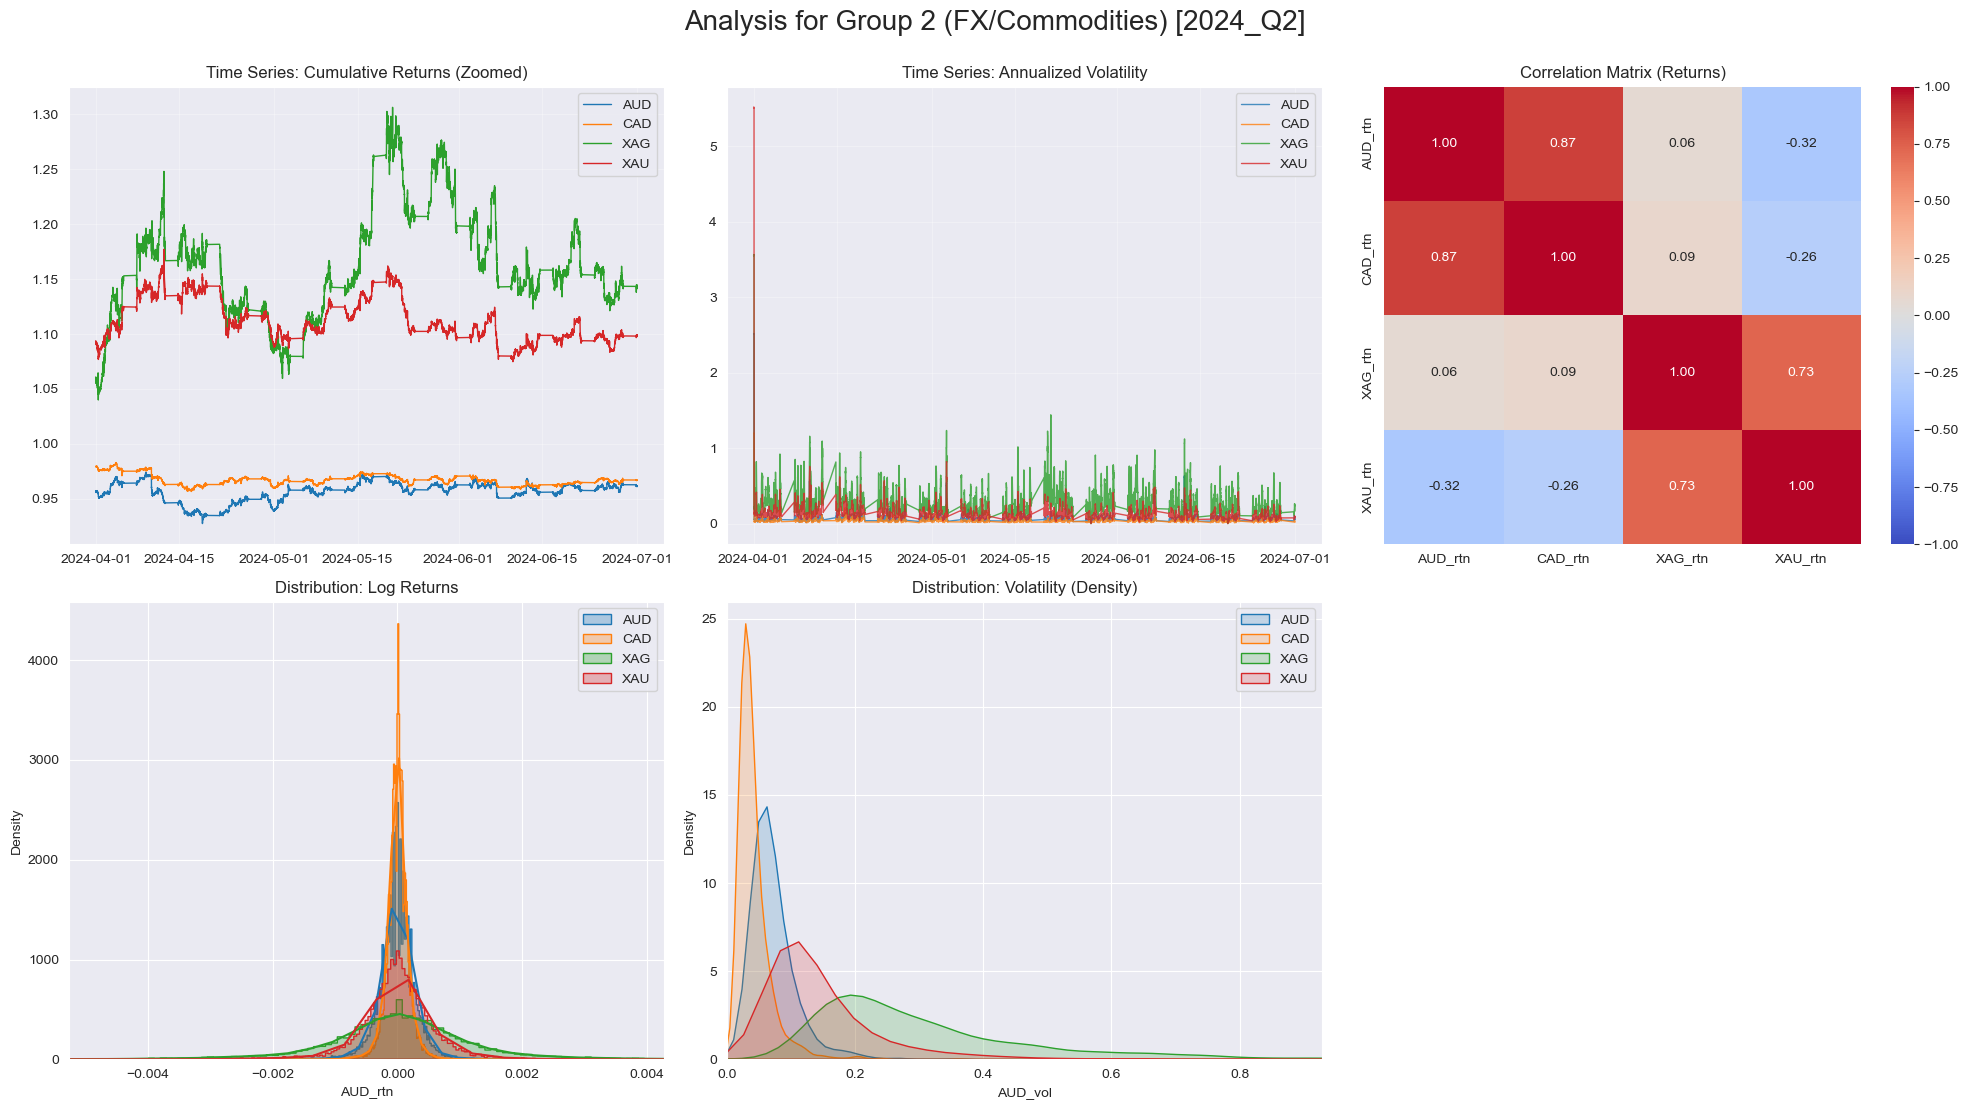

------------------------------
 > Quarter: 2024_Q4


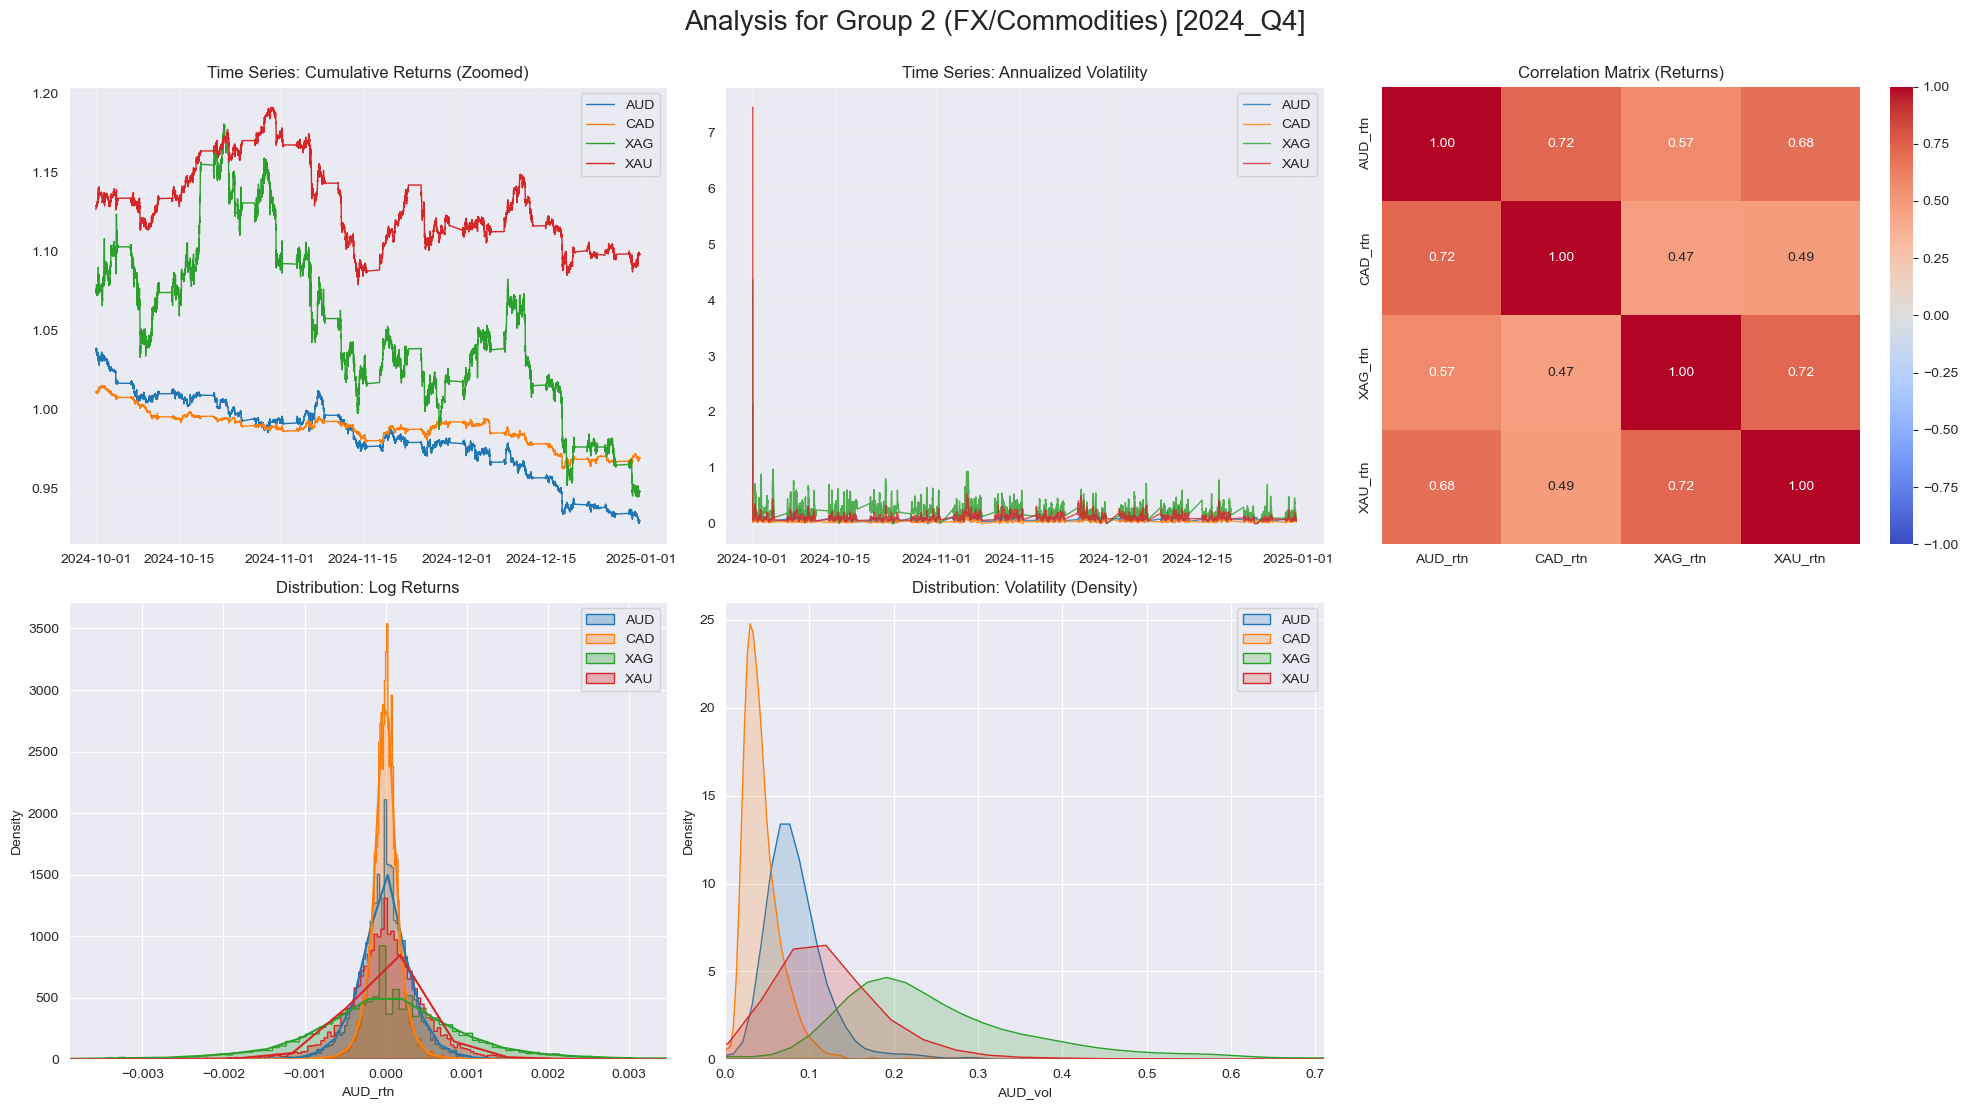

------------------------------
 > Quarter: 2025_Q1


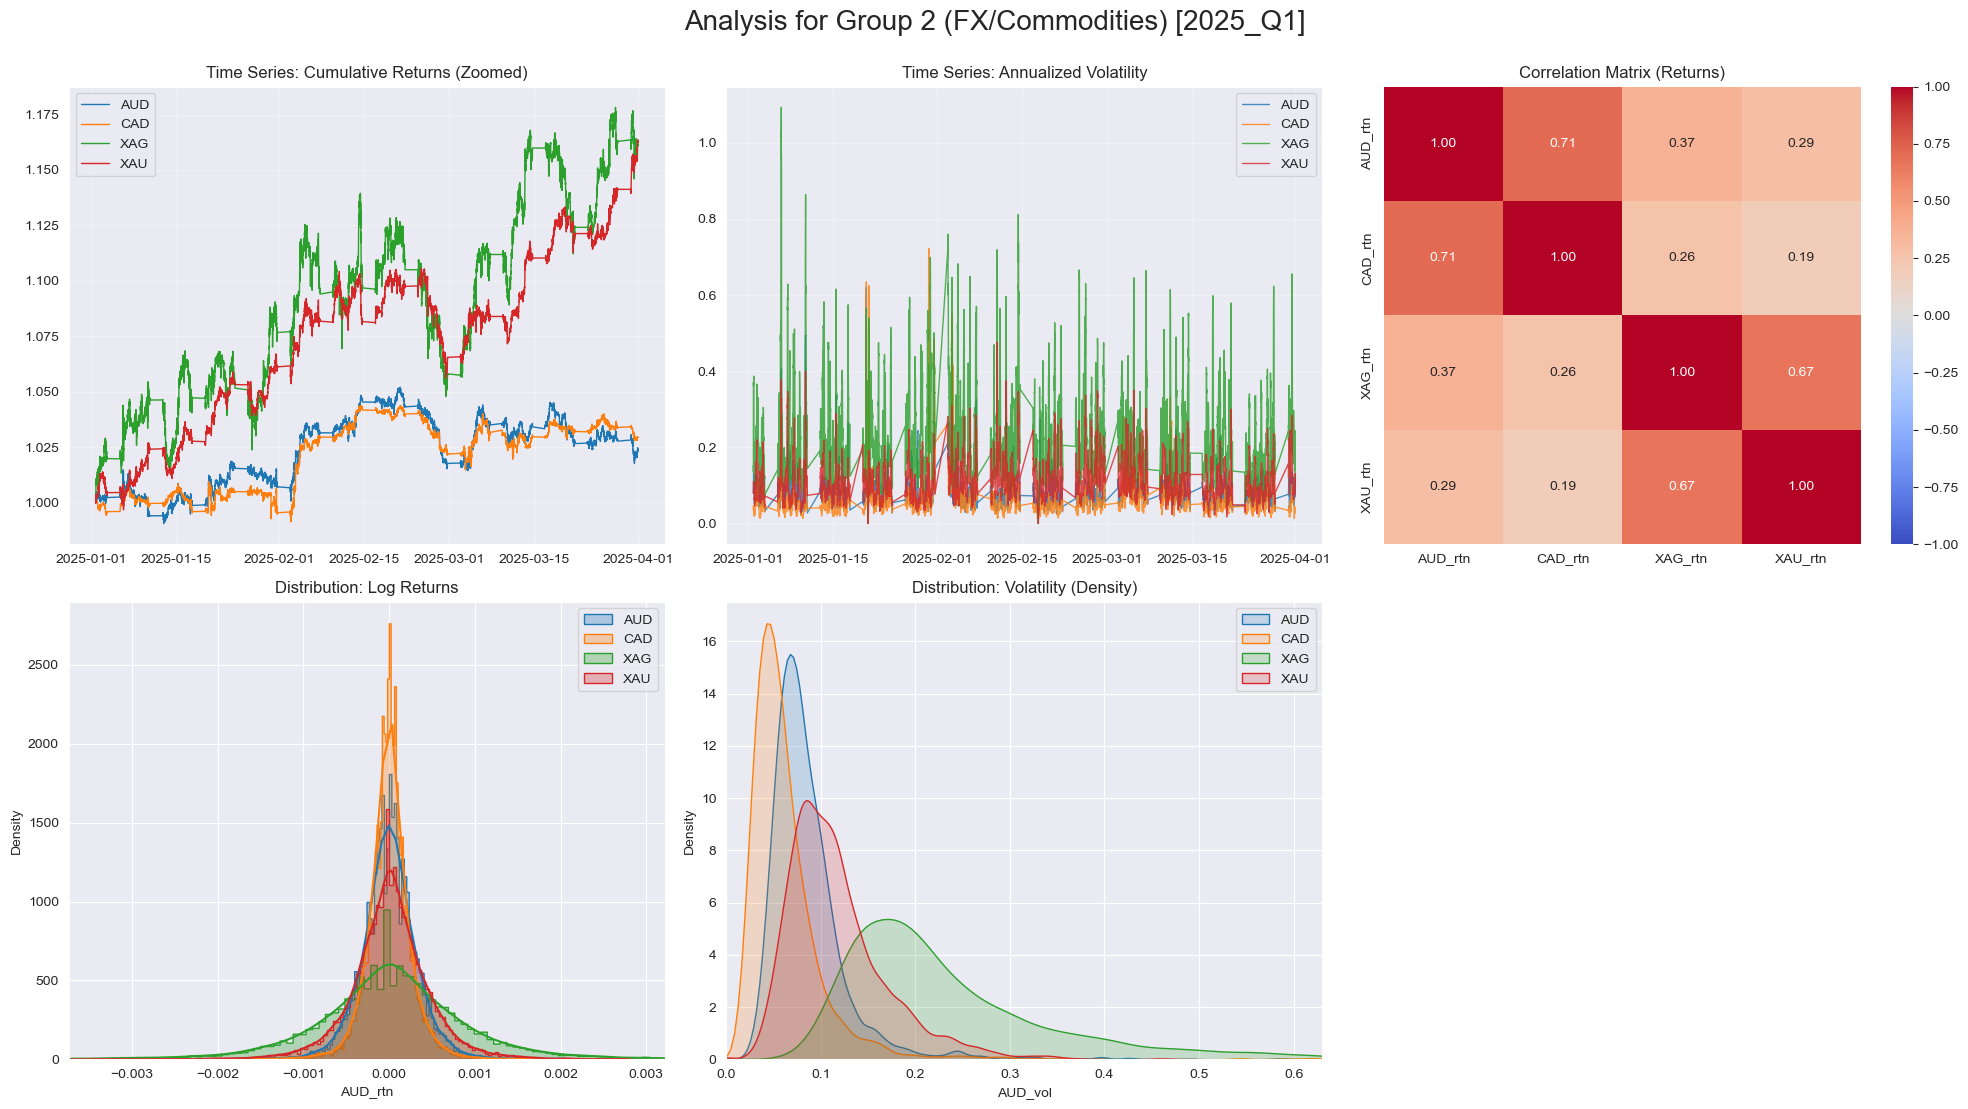

------------------------------
 > Quarter: 2025_Q2


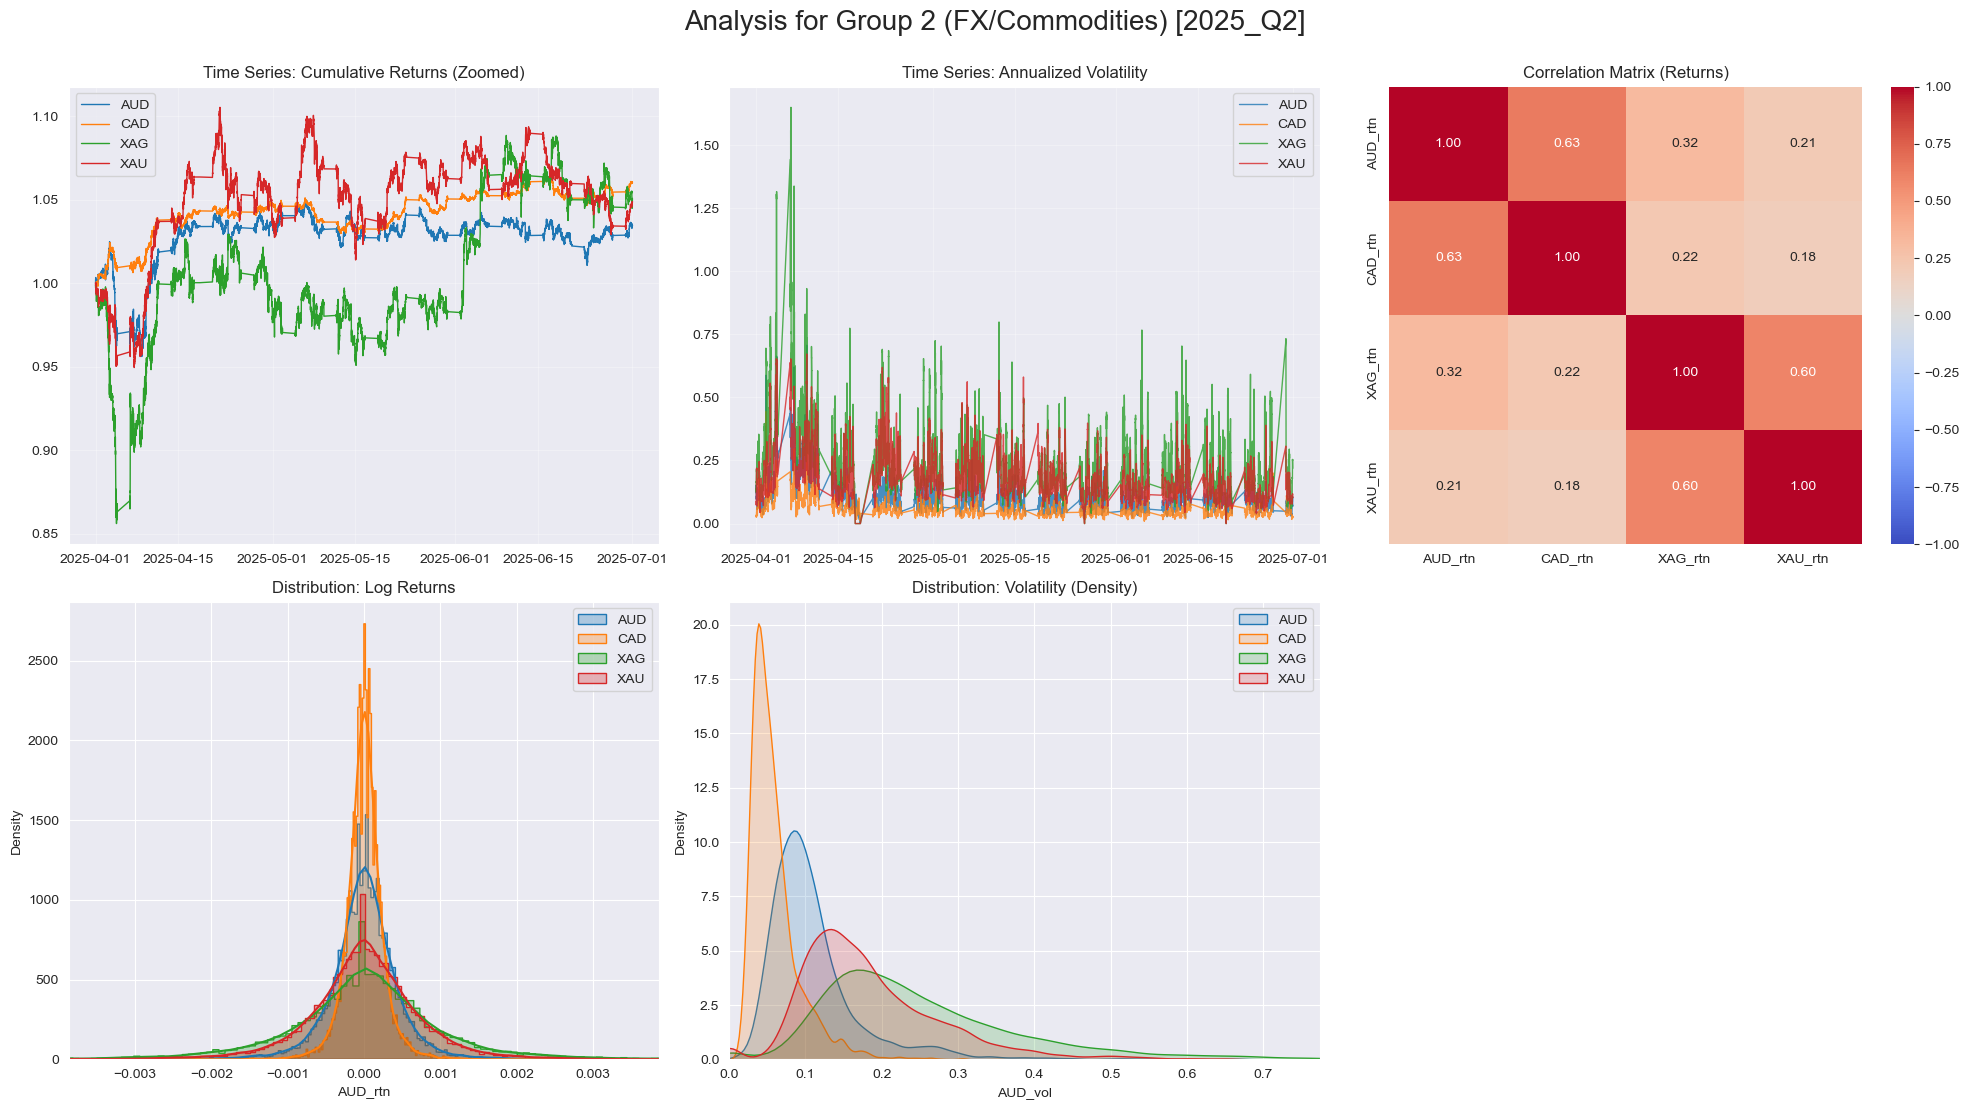

------------------------------


In [7]:
# ==========================================
# 4. Execution Logic
# ==========================================

def run_quarterly_analysis(df, group_label):
    if 'Quarter_ID' not in df.columns:
        print(f"Error: 'Quarter_ID' column not found in {group_label}")
        return

    quarters = df['Quarter_ID'].unique()
    quarters = sorted([q for q in quarters if pd.notna(q)])

    print(f"\nProcessing Quarterly Breakdown for: {group_label}")
    print(f"Quarters found: {len(quarters)}")

    for q in quarters:
        print(f" > Quarter: {q}")
        df_q = df[df['Quarter_ID'] == q].copy()
        plot_asset_group_analysis(df_q, group_label, quarter_id=q)
        print("-" * 30)

def run_full_analysis(df, group_label):
    """
    Runs both Seasonality (Full History) and Quarterly analysis.
    """
    print("\n" + "#"*60)
    print(f" FULL ANALYSIS START: {group_label}")
    print("#"*60)

    # 1. Seasonality (Requires full history, not sliced by quarter)
    plot_seasonality_analysis(df, group_label)

    # 2. Quarterly Breakdown
    run_quarterly_analysis(df, group_label)


# --- Run for Group 1 ---
run_full_analysis(df_g1, "Group 1 (Indices)")

# --- Run for Group 2 ---
run_full_analysis(df_g2, "Group 2 (FX/Commodities)")

Error: File not found.


## Exploratory Data Analysis (EDA) Insights

### A. Cumulative Returns \
* **Interpretation:** NQ (Nasdaq / Orange) and SP (S&P 500 / Blue) exhibit an **extremely high positive correlation**. However, it is evident that **NQ has higher volatility and delivers better performance during rising markets** (indicating a high beta).
* **Characteristics:** While the overall trend is upward, there are significant drawdowns during mid-2023 and early 2024.
* **Implication:** A simple "Long Only" strategy works fundamentally, but **robust drawdown management** is required during downturns.

### B. Annualized Volatility
* **Interpretation:** Periodic **massive spikes** are visible in the volatility data.
* **⚠️ Note:** The triangular shape of these spikes appears unnatural.
    > **This is primarily due to an Out-of-Sample period existing within the dataset.** The discontinuity in the data timeline during this period affects the rolling calculation, resulting in these irregular shapes.
* **Characteristics:** Volatility remains low during normal conditions but jumps significantly during specific events (or data discontinuities). NQ consistently maintains a higher base volatility than SP.
* **Implication:** Filtering mechanisms, such as "**halting trading when volatility exceeds a certain level**" or conversely "**targeting volatility breakouts**," would be effective.

### C. Return & Volatility Distributions
* **Interpretation:**
    * **High Kurtosis (Leptokurtic):** Data is highly concentrated around 0 (little to no change), indicating long periods where the market remains stagnant.
    * **Fat Tails:** The tails are wider than a normal distribution, indicating that **extreme price movements (surges or crashes)** occur more frequently than expected by standard models.
* **Implication:** On a 1-minute timeframe, the majority of the data is "noise." Attempting to capture every small movement will result in **profits being eroded by transaction costs**.
*